# Project Time Series Workshop I Part 2

```
By: Costin-Andrei Taulescu & Panagiotis Valsamis
```

**Overview**
In the following part of the project, we will use one store from our data with aggregated sales information for all its deparments. The goal is to create a model that will be able to predict as much accurate as possible the sales on the horizon of two weeks. If we are able to predict with high accuracy then we will know the order that needs to be placed in order to satisfy the demand and the main goal is to maximize a rebate laid out in a contract between the store and its supplier.

**Evaluation Metric**

The evaluation metric we will use will be the sum of forecasts for every month minus the sum of the actuals divided by the sum of the actuals. The sum will be 4 or 5 weeks depending on the month and if the final percentage is between a range that will be determined later we will get the rebate.

**Formula**
$\rho_m = \frac{\sum_i f_i - \sum_i a_i}{\sum_i a_i}$

**NOTE**
```
If pm is +10% on the one week, and -10% on the other week in the end of the month it will cancel out.
```

**Procedure**

We will use the last 6 weeks of the data as testing data. So we will train the data based on the other weeks. We will use grid search to optimize the TES algorithm and find the best possible model that can perform good in two week horizons. Based on the each month performance of just the last whole year, we will calculate the X% range, in which just the 6/12 months of the last year will be in that range. If we are able to predict the sales in that range we will get the rebate. After this, we will try to define a strategy that can be performed in order to include more of these months in the range and maximize the chances of getting the rebate. This strategy might not be statistically proved, but it might be more intuitive based on the data that we have. For example, one intuition might be if our model for example overperforms in the first two weeks of the month and underperforms in the last two weeks of the month, we might want to adjust our forecast for the last two weeks based on the error that we had in the first two weeks(like to reduce a percentage on every first two weeks and add a percentage of every two last weeks on each month). Finally, based on our best model, we will try to make predictions for the last 6 weeks of data that we leave out and check performance there, even this might not be very useful, since our goal here is not to evaluate our model based on completely unknown data, since the time series are clearly seasonal, so we need to find the best possible way to model them.


---

In [183]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
import locale
locale.setlocale(locale.LC_TIME, "English_United States.1252")

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

import matplotlib.dates as mdates

### Step 1: Importing and Visualizing the Data of Store 2

- As we also used on the first part of the project, we will use the store 2 data(just to have some different data exploration from part 1), after aggregated for all its departments. We will visualize the aggregated time series in order to see its main characteristics. We expect clear seasonality and not trend on the data(based on our findings from part 1).

**Data Preprocessing:**

- Leave last 6 weeks out
- Remove negative values
- Aggregate sales for all departments


In [184]:
def load_and_prepare_data(filepath, store_id=2, test_weeks=6):
    """
    Load Walmart data and prepare it for a specific store.
    
    Parameters:
    filepath : str, path to the CSV file
    store_id : int, store ID to extract
    test_weeks : int, number of weeks to reserve for testing
    
    Returns:
    train_df : DataFrame, training data
    test_df : DataFrame, testing data
    df_full : DataFrame, complete data for reference
    """
    print("="*60)
    print(f"STEP 2: LOADING DATA FOR STORE {store_id}")
    print("="*60)
    
    # Load data
    df = pd.read_csv(filepath)
    
    # Filter for specific store
    df = df[df['Store'] == store_id].copy()
    
    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort by date
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Handle negative sales
    df["Weekly_Sales"] = df["Weekly_Sales"].where(df["Weekly_Sales"] >= 0, 0)

    # Aggregate to store level (sum across all departments)
    df_store = df.groupby('Date').agg({
        'Weekly_Sales': 'sum',
        'IsHoliday': 'first'
    }).reset_index()
    
    # Add time features
    df_store['Year'] = df_store['Date'].dt.year
    df_store['Month'] = df_store['Date'].dt.month
    df_store['Week'] = df_store['Date'].dt.isocalendar().week
    
    print(f" Data loaded successfully!")
    print(f"  Date range: {df_store['Date'].min()} to {df_store['Date'].max()}")
    print(f"  Total weeks: {len(df_store)}")
    print(f"  First day of week: {df_store['Date'].iloc[0].strftime('%A')}")
    
    # Split into train and test
    split_point = len(df_store) - test_weeks
    train_df = df_store.iloc[:split_point].copy()
    test_df = df_store.iloc[split_point:].copy()
    
    print(f"\n Data split:")
    print(f"  Training: {len(train_df)} weeks ({train_df['Date'].min()} to {train_df['Date'].max()})")
    print(f"  Testing:  {len(test_df)} weeks ({test_df['Date'].min()} to {test_df['Date'].max()})")
    
    # Basic statistics
    print(f"\n Training data statistics:")
    print(f"  Mean:   {train_df['Weekly_Sales'].mean():,.2f}")
    print(f"  Std:    {train_df['Weekly_Sales'].std():,.2f}")
    print(f"  Min:    {train_df['Weekly_Sales'].min():,.2f}")
    print(f"  Max:    {train_df['Weekly_Sales'].max():,.2f}")
    
    return train_df, test_df, df_store


train_df,test_df,df_store = load_and_prepare_data("data/train.csv", store_id=2, test_weeks=6)


STEP 2: LOADING DATA FOR STORE 2
 Data loaded successfully!
  Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
  Total weeks: 143
  First day of week: Friday

 Data split:
  Training: 137 weeks (2010-02-05 00:00:00 to 2012-09-14 00:00:00)
  Testing:  6 weeks (2012-09-21 00:00:00 to 2012-10-26 00:00:00)

 Training data statistics:
  Mean:   1,928,684.34
  Std:    241,920.08
  Min:    1,650,394.44
  Max:    3,436,154.68



VISUALIZING TRAINING DATA


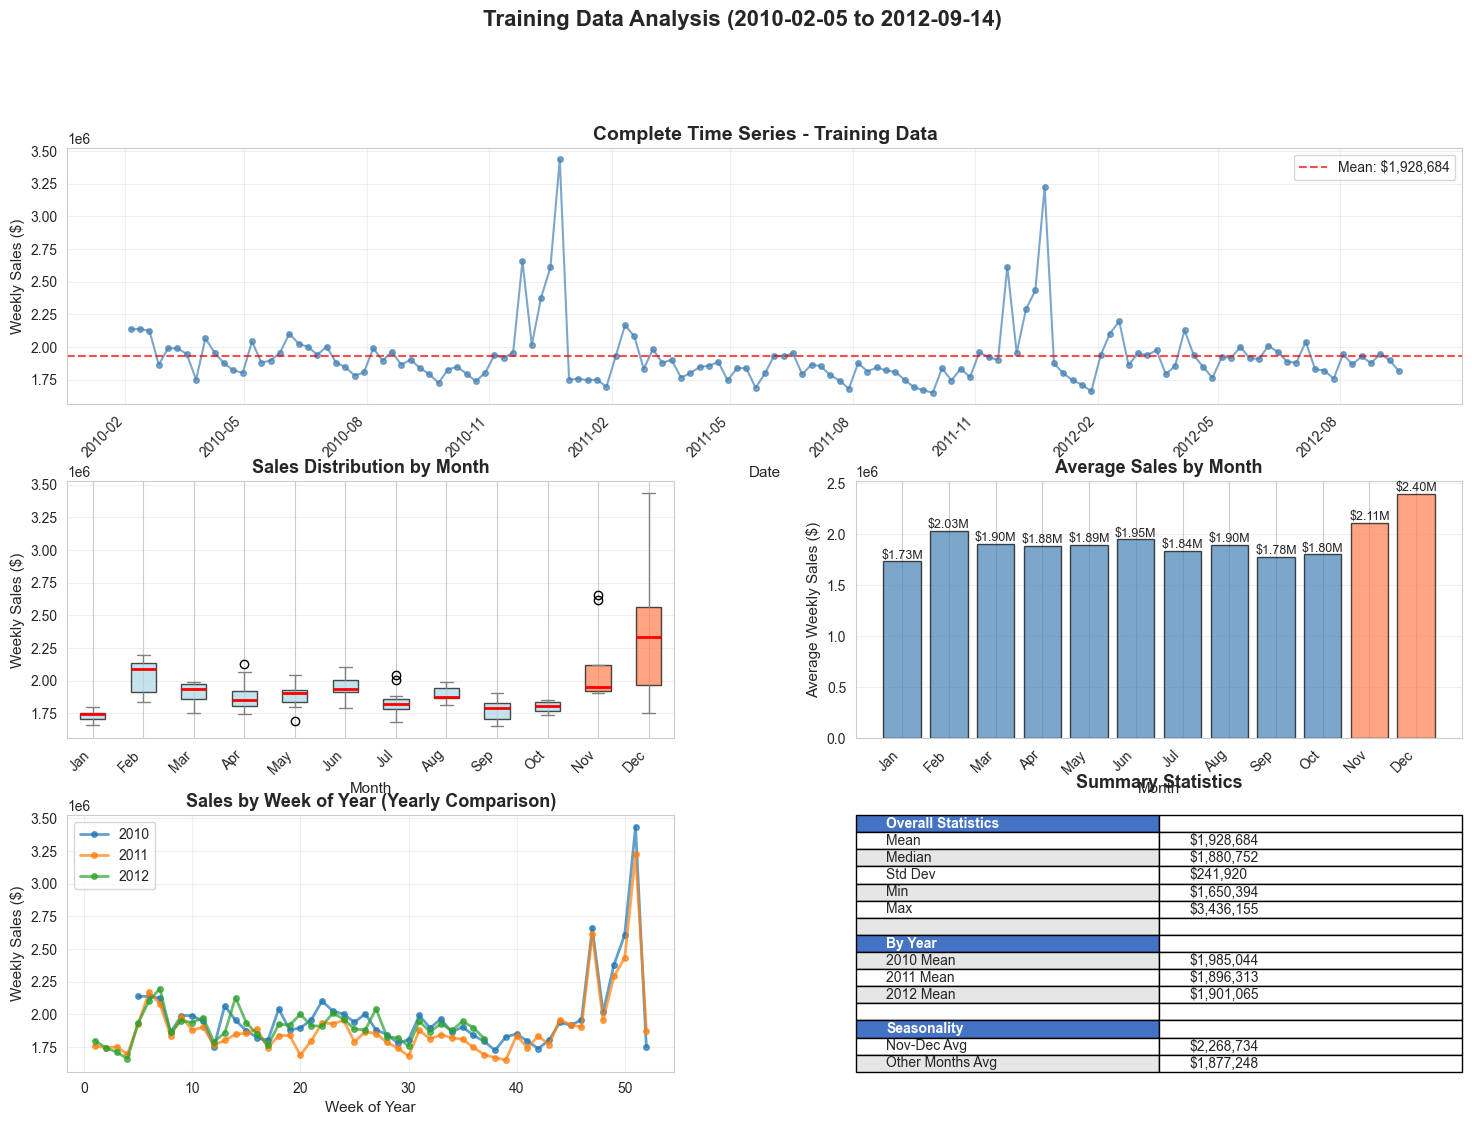


Visualization complete!

CREATING MONTHLY BREAKDOWN


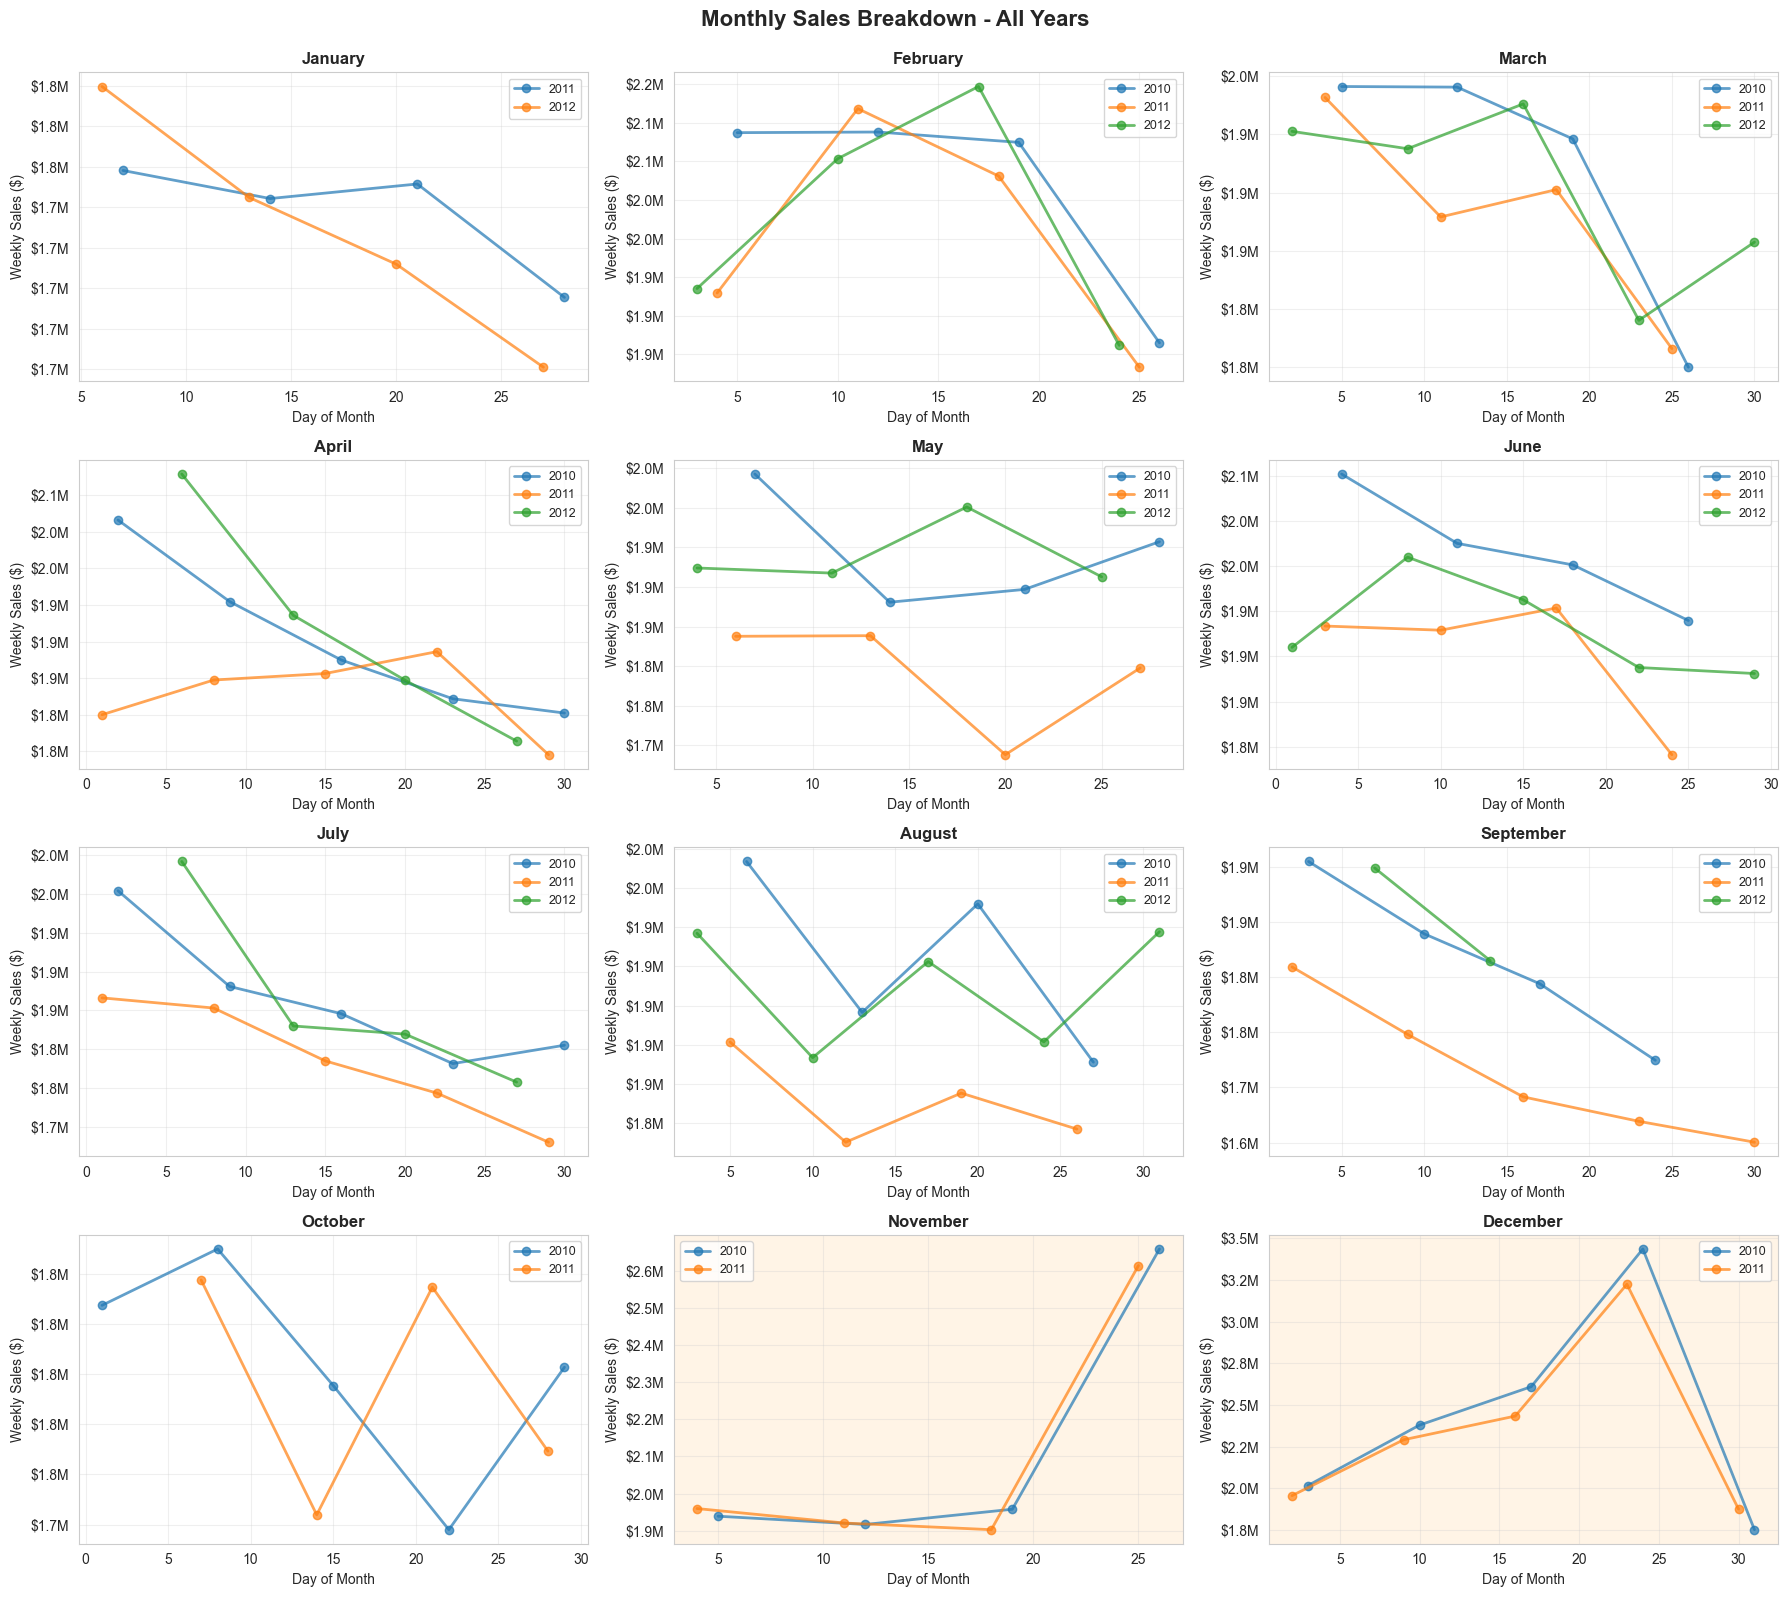


Monthly breakdown complete!


In [185]:
def visualize_training_data(train_df):
    """
    Create comprehensive visualizations of training data for Jupyter notebook.
    
    Parameters:
    -----------
    train_df : DataFrame with columns ['Date', 'Weekly_Sales', 'Month', 'Year']
    """
    
    print("\n" + "="*60)
    print("VISUALIZING TRAINING DATA")
    print("="*60)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Complete time series
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(train_df['Date'], train_df['Weekly_Sales'], 
             'o-', linewidth=1.5, markersize=4, alpha=0.7, color='steelblue')
    ax1.set_title('Complete Time Series - Training Data', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=11)
    ax1.set_ylabel('Weekly Sales ($)', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add mean line
    mean_sales = train_df['Weekly_Sales'].mean()
    ax1.axhline(mean_sales, color='red', linestyle='--', linewidth=1.5, 
                alpha=0.7, label=f'Mean: ${mean_sales:,.0f}')
    ax1.legend(fontsize=10)
    
    # 2. Sales by Month (Boxplot)
    ax2 = fig.add_subplot(gs[1, 0])
    month_order = list(range(1, 13))
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    box_data = [train_df[train_df['Month'] == m]['Weekly_Sales'].values 
                for m in month_order]
    
    bp = ax2.boxplot(box_data, labels=month_names, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(color='gray'),
                     capprops=dict(color='gray'))
    
    ax2.set_title('Sales Distribution by Month', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Month', fontsize=11)
    ax2.set_ylabel('Weekly Sales ($)', fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Highlight holiday months
    for i, month in enumerate([11, 12], start=10):  # Nov=10, Dec=11 (0-indexed)
        bp['boxes'][i].set_facecolor('coral')
        bp['boxes'][i].set_alpha(0.7)
    
    # 3. Average Sales by Month (Bar Chart)
    ax3 = fig.add_subplot(gs[1, 1])
    monthly_avg = train_df.groupby('Month')['Weekly_Sales'].mean().reindex(month_order)
    
    colors = ['coral' if m in [11, 12] else 'steelblue' for m in month_order]
    bars = ax3.bar(month_names, monthly_avg.values, color=colors, alpha=0.7, edgecolor='black')
    
    ax3.set_title('Average Sales by Month', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Month', fontsize=11)
    ax3.set_ylabel('Average Weekly Sales ($)', fontsize=11)
    ax3.grid(True, alpha=0.3, axis='y')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'${height/1e6:.2f}M',
                ha='center', va='bottom', fontsize=9)
    
    # 4. Yearly Comparison
    ax4 = fig.add_subplot(gs[2, 0])
    
    for year in sorted(train_df['Year'].unique()):
        year_data = train_df[train_df['Year'] == year].copy()
        year_data = year_data.sort_values('Date')
        
        # Create week of year
        year_data['WeekOfYear'] = year_data['Date'].dt.isocalendar().week
        
        ax4.plot(year_data['WeekOfYear'], year_data['Weekly_Sales'], 
                'o-', label=f'{year}', linewidth=2, markersize=4, alpha=0.7)
    
    ax4.set_title('Sales by Week of Year (Yearly Comparison)', fontsize=13, fontweight='bold')
    ax4.set_xlabel('Week of Year', fontsize=11)
    ax4.set_ylabel('Weekly Sales ($)', fontsize=11)
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)
    
    # 5. Sales Statistics Table
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.axis('off')
    
    # Calculate statistics
    stats_data = []
    stats_data.append(['Overall Statistics', ''])
    stats_data.append(['Mean', f'${train_df["Weekly_Sales"].mean():,.0f}'])
    stats_data.append(['Median', f'${train_df["Weekly_Sales"].median():,.0f}'])
    stats_data.append(['Std Dev', f'${train_df["Weekly_Sales"].std():,.0f}'])
    stats_data.append(['Min', f'${train_df["Weekly_Sales"].min():,.0f}'])
    stats_data.append(['Max', f'${train_df["Weekly_Sales"].max():,.0f}'])
    stats_data.append(['', ''])
    stats_data.append(['By Year', ''])
    
    for year in sorted(train_df['Year'].unique()):
        year_data = train_df[train_df['Year'] == year]
        stats_data.append([f'{year} Mean', f'${year_data["Weekly_Sales"].mean():,.0f}'])
    
    stats_data.append(['', ''])
    stats_data.append(['Seasonality', ''])
    stats_data.append(['Nov-Dec Avg', f'${train_df[train_df["Month"].isin([11,12])]["Weekly_Sales"].mean():,.0f}'])
    stats_data.append(['Other Months Avg', f'${train_df[~train_df["Month"].isin([11,12])]["Weekly_Sales"].mean():,.0f}'])
    
    # Create table
    table = ax5.table(cellText=stats_data, cellLoc='left',
                     loc='center', bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(stats_data)):
        cell = table[(i, 0)]
        if stats_data[i][0] in ['Overall Statistics', 'By Year', 'Seasonality']:
            cell.set_facecolor('#4472C4')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#E7E6E6' if i % 2 == 0 else 'white')
    
    ax5.set_title('Summary Statistics', fontsize=13, fontweight='bold', pad=20)
    
    plt.suptitle(f'Training Data Analysis ({train_df["Date"].min().strftime("%Y-%m-%d")} to {train_df["Date"].max().strftime("%Y-%m-%d")})',
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization complete!")


def plot_monthly_breakdown(train_df):
    """
    Create individual plots for each month across all years.
    
    Parameters:
    -----------
    train_df : DataFrame with training data
    """
    
    print("\n" + "="*60)
    print("CREATING MONTHLY BREAKDOWN")
    print("="*60)
    
    # Create figure with 12 subplots (one per month)
    fig, axes = plt.subplots(4, 3, figsize=(18, 16))
    axes = axes.flatten()
    
    month_names = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    for month_num, (ax, month_name) in enumerate(zip(axes, month_names), start=1):
        month_data = train_df[train_df['Month'] == month_num].copy()
        
        if len(month_data) > 0:
            # Group by year for this month
            for year in sorted(month_data['Year'].unique()):
                year_month_data = month_data[month_data['Year'] == year].sort_values('Date')
                
                # Use day of month for x-axis
                year_month_data['Day'] = year_month_data['Date'].dt.day
                
                ax.plot(year_month_data['Day'], year_month_data['Weekly_Sales'],
                       'o-', label=f'{year}', linewidth=2, markersize=6, alpha=0.7)
            
            ax.set_title(month_name, fontsize=12, fontweight='bold')
            ax.set_xlabel('Day of Month', fontsize=10)
            ax.set_ylabel('Weekly Sales ($)', fontsize=10)
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.ticklabel_format(style='plain', axis='y')
            
            # Format y-axis
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
            
            # Highlight if holiday month
            if month_num in [11, 12]:
                ax.set_facecolor('#fff4e6')
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center',
                   transform=ax.transAxes, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.suptitle(f'Monthly Sales Breakdown - All Years', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\nMonthly breakdown complete!")


visualize_training_data(train_df)
plot_monthly_breakdown(train_df)

**Notes:**

- Based on the first image, with the whole time series (and more with the time series grouping by year) help us to undestand that there seems to be clear seasonality on the data, with peaks around the end of each year and lower sales on the middle of the year. There is no clear trend on the data, so we will not need to difference the data for trend removal(however we will test it with the same statistical models we used on part 1, to be sure that our first impression is correct).
- The second image, provide us with a zoomed in version of the months of data(with grouping by year as well), where we can see more clearly the seasonality in every month seperately.
- The table on the first plot, provide us with the main statistics of the data, where we can see that the mean is higher than the median, so there is some positive skewness on the data, which is also visible on the histogram plot.
- November and December seems to be the months with the highest sales, while January seems to be the month with the lowest sales.
- Based on the mean of each year, we can **not** claim that there is a decreasing trend
- It is worth mentioning to take into consideration the last week of November in every year, where there is a clear peak in sales, which is probably due to Black Friday sales.
- There is clear peak in December, probably due to Christmas sales.
- It is worth mentioning that in every month except November, the last week of the month seems to have lower sales than the other weeks of the month.

---

### Statistical Testing for Trend using run_trend_analysis python script

In [186]:
from run_trend_analysis import analyze_series

# Pass only the Weekly_Sales column, not the entire DataFrame
analyze_series(train_df['Weekly_Sales'], series_name="Store 1 Training Data")


######################################################################
COMPREHENSIVE TREND ANALYSIS FOR: Store 1 Training Data
######################################################################

Data points: 137
Mean: 1928684.34
Std Dev: 241035.54
Min: 1650394.44
Max: 3436154.68

1. MANN-KENDALL TEST (Non-parametric)
Trend: no trend
Test Statistic (S): -634.0
p-value: 0.238837
Tau (correlation): -0.068055
z-score: -1.177899

 RESULT: No significant trend (p >= 0.05)

2. AUGMENTED DICKEY-FULLER (ADF) TEST
ADF Statistic: -3.632909
p-value: 0.005162
Lags used: 6
Number of observations: 130

Critical Values:
  1%: -3.482
  5%: -2.884
  10%: -2.579

 RESULT: Series is stationary (p < 0.05)
   No unit root → Suggests NO trend

3. KPSS TEST (Kwiatkowski-Phillips-Schmidt-Shin)
KPSS Test (with trend):
KPSS Statistic: 0.053766
p-value: 0.100000
Lags used: 4

Critical Values:
  10%: 0.119
  5%: 0.146
  2.5%: 0.176
  1%: 0.216

 RESULT: Series is trend stationary (p >= 0.05)
   Null hypothesi

{'mann_kendall': Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.2388367980146735), z=np.float64(-1.177899190096128), Tau=np.float64(-0.06805495920996135), s=np.float64(-634.0), var_s=288796.0, slope=np.float64(-334.9469135802478), intercept=np.float64(1903528.750123457)),
 'adf': (np.float64(-3.632908538595409),
  np.float64(0.005162172372729846),
  6,
  130,
  {'1%': np.float64(-3.4816817173418295),
   '5%': np.float64(-2.8840418343195267),
   '10%': np.float64(-2.578770059171598)},
  np.float64(3379.2610933517135)),
 'kpss': (np.float64(0.05376614062759631),
  np.float64(0.1),
  4,
  {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}),
 'linear_regression': {'slope': np.float64(-328.4893946832941),
  'intercept': np.float64(1951021.6170866392),
  'p_value': np.float64(0.5316335569158772),
  'r_squared': np.float64(0.0029048070660622066),
  'std_err': np.float64(523.7983592507323)},
 'cox_stuart': {'plus': np.int64(31),
  'minus': np.int64(37),
  'p_value': np.fl

**Statistical Test Results:**
- 6 different trend tests performed (ADF, KPSS, Mann-Kendall, Linear Regression, Cox-Stuart, Spearman)
- **Conclusion**: No significant trend detected (p-values indicate stationarity)
- **Implication**: We set β=0 in our Holt-Winters model
- **Justification**: Data shows strong seasonality but no systematic growth/decline over time

---

# Question 1
## Fitting TES and grid searching for parameters

**Note:**
```
Even if we concluded above that there seems not to exist trend on our data, we will use a beta parameter for the trend and we expect from our ideal model to produce a very small number of this parameter.
```

### Using Additive Seasonality

In [187]:
# ============================================
# PART 2: STEP 1 - OPTIMIZE PARAMETERS AND GENERATE HORIZON-2 FORECASTS
# ============================================

# Same as in part1

def TSE(y_true,y_pred):
    return np.sum((y_true - y_pred)**2)


def hw_seasonal_no_trend(y,alpha,gamma,m):
    """
    Holt-Winters Seasonal Method without Trend
    y: time series data
    alpha: level smoothing parameter
    gamma: seasonal smoothing parameter
    m:season length
    """

    n =len(y)
    # Initialization
    level = np.mean(y[:m])  # Mean of first seasonal cycle
    seasonals = list(y[:m] - level)  # Seasonal components for first cycle

    fitted = [np.nan]*n

    for t in range(m,n):
        fitted[t] = level + seasonals[t -  m]

        new_level = alpha * (y[t] - seasonals[t - m]) + (1 - alpha) * level
        new_seasonal = gamma * (y[t] - new_level) + (1 - gamma) * seasonals[t - m]

        level = new_level
        seasonals.append(new_seasonal)

    return np.array(fitted), level, seasonals


def optimize_hw_additive(train_df, season_length=52):
    """
    Optimize Holt-Winters ADDITIVE model (no trend) for Part 2.
    Uses your existing hw_seasonal_no_trend function.
    
    Returns:
    --------
    best_params : tuple (alpha, gamma)
    best_model : tuple (level, seasonals)
    best_tse : float
    """
    
    print("="*60)
    print("OPTIMIZING HOLT-WINTERS (ADDITIVE, NO TREND)")
    print("="*60)
    
    y_train = train_df['Weekly_Sales'].values
    m = season_length
    
    # Define parameter ranges
    alphas = np.arange(0.05, 1.0, 0.05)
    gammas = np.arange(0.05, 1.0, 0.05)
    
    best_tse = np.inf
    best_params = None
    best_model = None
    
    print(f"\nTraining data: {len(y_train)} weeks")
    print(f"Testing {len(alphas)} × {len(gammas)} = {len(alphas)*len(gammas)} combinations...")
    
    # Grid search
    for alpha in alphas:
        for gamma in gammas:
            try:
                fitted, level, seasonals = hw_seasonal_no_trend(y_train, alpha, gamma, m)
                
                # Calculate TSE on valid data
                valid_idx = ~np.isnan(fitted)
                tse = TSE(y_train[valid_idx], fitted[valid_idx])
                
                if tse < best_tse:
                    best_tse = tse
                    best_params = (alpha, gamma)
                    best_model = (level, seasonals)
            except:
                continue
    
    print(f"\n Optimization complete!")
    print(f"\n{'='*60}")
    print("OPTIMAL PARAMETERS")
    print(f"{'='*60}")
    print(f"  α (level):    {best_params[0]:.3f}")
    print(f"  γ (seasonal): {best_params[1]:.3f}")
    print(f"  β (trend):    0.000 (fixed, no trend)")
    print(f"\nTraining TSE: {best_tse:,.2f}")
    print(f"Training RMSE: {np.sqrt(best_tse/len(y_train)):,.2f}")
    
    return best_params, best_model, best_tse


def generate_horizon2_forecasts_hw(train_df, test_df, best_params, season_length=52):
    """
    Generate HORIZON-2 forecasts for test period using Holt-Winters.
    
    This is different from Part 1:
    - Part 1: horizon-1 (one week ahead)
    - Part 2: horizon-2 (TWO weeks ahead)
    
    Parameters:
    -----------
    train_df : DataFrame with training data
    test_df : DataFrame with test data  
    best_params : tuple (alpha, gamma) from optimization
    season_length : int, 52 for weekly data
    
    Returns:
    --------
    results_df : DataFrame with Date, Actual, Forecast_H2
    metrics : dict with MAE, MAPE, RMSE
    """
    
    print("\n" + "="*60)
    print("GENERATING HORIZON-2 FORECASTS FOR TEST SET")
    print("="*60)
    
    alpha_best, gamma_best = best_params
    m = season_length
    
    # Combine train and test
    full_data = pd.concat([train_df, test_df], ignore_index=True)
    split_point = len(train_df)
    
    forecasts_h2 = []
    actuals = []
    dates = []
    
    print(f"\nGenerating horizon-2 forecasts for {len(test_df)} test weeks...")
    
    for i in range(len(test_df)):
        # Use data up to current point (including i weeks of test data)
        current_data = full_data.iloc[:split_point + i]['Weekly_Sales'].values
        
        # Fit model
        fitted, level, seasonals = hw_seasonal_no_trend(current_data, alpha_best, gamma_best, m)
        
        # Generate 2-week ahead forecast
        seasonals = np.array(seasonals)
        
        # Horizon-2 forecast (2 weeks ahead)
        seasonal_index_h2 = len(seasonals) - m + 1  # +1 for horizon-2
        forecast_h2 = level + seasonals[seasonal_index_h2]
        
        forecasts_h2.append(forecast_h2)
        actuals.append(test_df.iloc[i]['Weekly_Sales'])
        dates.append(test_df.iloc[i]['Date'])
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'Date': dates,
        'Actual': actuals,
        'Forecast_H2': forecasts_h2
    })
    
    # Calculate metrics
    mae = np.mean(np.abs(results_df['Actual'] - results_df['Forecast_H2']))
    mape = np.mean(np.abs((results_df['Actual'] - results_df['Forecast_H2']) / results_df['Actual'])) * 100
    rmse = np.sqrt(np.mean((results_df['Actual'] - results_df['Forecast_H2'])**2))
    
    metrics = {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }
    
    print(f"\n✓ Horizon-2 forecasts generated!")
    print(f"\n{'='*60}")
    print("HORIZON-2 FORECAST ACCURACY (TEST SET)")
    print(f"{'='*60}")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  RMSE: ${rmse:,.2f}")
    
    return results_df, metrics


def plot_horizon2_results(results_df, best_params):
    """
    Visualize horizon-2 forecast results.
    """
    import matplotlib.dates as mdates
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    alpha_best, gamma_best = best_params
    
    # Plot 1: Forecasts vs Actuals
    ax1 = axes[0]
    ax1.plot(results_df['Date'], results_df['Actual'], 
             'o-', label='Actual Sales', linewidth=2.5, markersize=10, 
             color='black', zorder=3)
    ax1.plot(results_df['Date'], results_df['Forecast_H2'], 
             's--', label='Horizon-2 Forecasts', linewidth=2.5, markersize=10,
             color='steelblue', zorder=3)
    
    ax1.set_title(f'Horizon-2 Forecasts vs Actuals (Test Period)\nα={alpha_best:.3f}, γ={gamma_best:.3f}, β=0.000 (no trend)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Weekly Sales ($)', fontsize=12)
    ax1.legend(fontsize=11, loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add error bands
    for i in range(len(results_df)):
        ax1.plot([results_df['Date'].iloc[i], results_df['Date'].iloc[i]], 
                [results_df['Actual'].iloc[i], results_df['Forecast_H2'].iloc[i]],
                'r--', alpha=0.3, linewidth=1)
    
    # Plot 2: Errors
    ax2 = axes[1]
    errors = results_df['Forecast_H2'] - results_df['Actual']
    abs_errors = np.abs(errors)
    
    colors = ['green' if e >= 0 else 'red' for e in errors]
    ax2.bar(results_df['Date'], errors, color=colors, alpha=0.6, edgecolor='black')
    ax2.axhline(0, color='black', linewidth=1.5, linestyle='-')
    
    ax2.set_title('Forecast Errors (Forecast - Actual)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Error ($)', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add mean absolute error line
    mae = np.mean(abs_errors)
    ax2.axhline(mae, color='blue', linewidth=2, linestyle='--', 
                label=f'MAE = ${mae:,.0f}', alpha=0.7)
    ax2.axhline(-mae, color='blue', linewidth=2, linestyle='--', alpha=0.7)
    ax2.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()




### Multiplicative Seasonality

In [188]:
def hw_seasonal_no_trend_multiplicative(y, alpha, gamma, m):
    """
    Holt-Winters Seasonal Method without Trend - Multiplicative Seasonality
    y: time series data
    alpha: level smoothing parameter
    gamma: seasonal smoothing parameter
    m: season length
    """
    
    n = len(y)
    
    # Initialization
    level = np.mean(y[:m])
    seasonals = list(y[:m] / level)  # Multiplicative: divide instead of subtract
    
    fitted = [np.nan] * n
    
    for t in range(m, n):
        fitted[t] = level * seasonals[t - m]  # Multiplicative: multiply instead of add
        
        # Update level (deseasonalize by dividing)
        new_level = alpha * (y[t] / seasonals[t - m]) + (1 - alpha) * level
        
        # Update seasonal component (ratio)
        new_seasonal = gamma * (y[t] / new_level) + (1 - gamma) * seasonals[t - m]
        
        level = new_level
        seasonals.append(new_seasonal)
    
    return np.array(fitted), level, seasonals


# ============================================
# MULTIPLICATIVE VERSION
# ============================================

def optimize_hw_multiplicative(train_df, season_length=52):
    """
    Optimize Holt-Winters MULTIPLICATIVE model (no trend) for Part 2.
    Uses your existing hw_seasonal_multiplicative_no_trend function.
    
    Returns:
    --------
    best_params : tuple (alpha, gamma)
    best_model : tuple (level, seasonals)
    best_tse : float
    """
    
    print("="*60)
    print("OPTIMIZING HOLT-WINTERS (MULTIPLICATIVE, NO TREND)")
    print("="*60)
    
    y_train = train_df['Weekly_Sales'].values
    m = season_length
    
    # Define parameter ranges
    alphas = np.arange(0.05, 1.0, 0.05)
    gammas = np.arange(0.05, 1.0, 0.05)
    
    best_tse = np.inf
    best_params = None
    best_model = None
    
    print(f"\nTraining data: {len(y_train)} weeks")
    print(f"Testing {len(alphas)} × {len(gammas)} = {len(alphas)*len(gammas)} combinations...")
    
    # Grid search
    for alpha in alphas:
        for gamma in gammas:
            try:
                fitted, level, seasonals = hw_seasonal_no_trend_multiplicative(
                    y_train, alpha, gamma, m
                )
                
                # Calculate TSE on valid data
                valid_idx = ~np.isnan(fitted)
                tse = TSE(y_train[valid_idx], fitted[valid_idx])
                
                if tse < best_tse:
                    best_tse = tse
                    best_params = (alpha, gamma)
                    best_model = (level, seasonals)
            except:
                continue
    
    print(f"\n✓ Optimization complete!")
    print(f"\n{'='*60}")
    print("OPTIMAL PARAMETERS")
    print(f"{'='*60}")
    print(f"  α (level):    {best_params[0]:.3f}")
    print(f"  γ (seasonal): {best_params[1]:.3f}")
    print(f"  β (trend):    0.000 (fixed, no trend)")
    print(f"\nTraining TSE: {best_tse:,.2f}")
    print(f"Training RMSE: {np.sqrt(best_tse/len(y_train)):,.2f}")
    
    return best_params, best_model, best_tse


def generate_horizon2_forecasts_multiplicative(train_df, test_df, best_params, season_length=52):
    """
    Generate HORIZON-2 forecasts using MULTIPLICATIVE seasonality.
    
    Parameters:
    -----------
    train_df : DataFrame with training data
    test_df : DataFrame with test data  
    best_params : tuple (alpha, gamma) from optimization
    season_length : int, 52 for weekly data
    
    Returns:
    --------
    results_df : DataFrame with Date, Actual, Forecast_H2
    metrics : dict with MAE, MAPE, RMSE
    """
    
    print("\n" + "="*60)
    print("GENERATING HORIZON-2 FORECASTS (MULTIPLICATIVE)")
    print("="*60)
    
    alpha_best, gamma_best = best_params
    m = season_length
    
    # Combine train and test
    full_data = pd.concat([train_df, test_df], ignore_index=True)
    split_point = len(train_df)
    
    forecasts_h2 = []
    actuals = []
    dates = []
    
    print(f"\nGenerating horizon-2 forecasts for {len(test_df)} test weeks...")
    
    for i in range(len(test_df)):
        # Use data up to current point
        current_data = full_data.iloc[:split_point + i]['Weekly_Sales'].values
        
        # Fit model
        fitted, level, seasonals = hw_seasonal_no_trend_multiplicative(
            current_data, alpha_best, gamma_best, m
        )
        
        # Generate 2-week ahead forecast
        seasonals = np.array(seasonals)
        
        # Horizon-2 forecast (2 weeks ahead) - MULTIPLICATIVE
        seasonal_index_h2 = len(seasonals) - m + 1
        forecast_h2 = level * seasonals[seasonal_index_h2]  # Multiply instead of add
        
        forecasts_h2.append(forecast_h2)
        actuals.append(test_df.iloc[i]['Weekly_Sales'])
        dates.append(test_df.iloc[i]['Date'])
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'Date': dates,
        'Actual': actuals,
        'Forecast_H2': forecasts_h2
    })
    
    # Calculate metrics
    mae = np.mean(np.abs(results_df['Actual'] - results_df['Forecast_H2']))
    mape = np.mean(np.abs((results_df['Actual'] - results_df['Forecast_H2']) / results_df['Actual'])) * 100
    rmse = np.sqrt(np.mean((results_df['Actual'] - results_df['Forecast_H2'])**2))
    
    metrics = {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }
    
    print(f"\nHorizon-2 forecasts generated!")
    print(f"\n{'='*60}")
    print("HORIZON-2 FORECAST ACCURACY (TEST SET)")
    print(f"{'='*60}")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  RMSE: ${rmse:,.2f}")
    
    return results_df, metrics




### Comparison


In [189]:
# ============================================
# COMPARISON FUNCTION
# ============================================

def compare_additive_vs_multiplicative(train_df, test_df, season_length=52):
    """
    Compare Additive vs Multiplicative seasonality models.
    
    Returns:
    --------
    comparison_dict : dict with results for both models
    """
    
    print("\n" + "#"*70)
    print("COMPARING ADDITIVE VS MULTIPLICATIVE SEASONALITY")
    print("#"*70)
    
    # ===== ADDITIVE MODEL =====
    print("\n" + "="*70)
    print("MODEL 1: ADDITIVE SEASONALITY")
    print("="*70)
    
    params_add, model_add, tse_add = optimize_hw_additive(train_df, season_length)
    results_add, metrics_add = generate_horizon2_forecasts_hw(train_df, test_df, params_add, season_length)
    
    # ===== MULTIPLICATIVE MODEL =====
    print("\n" + "="*70)
    print("MODEL 2: MULTIPLICATIVE SEASONALITY")
    print("="*70)
    
    params_mult, model_mult, tse_mult = optimize_hw_multiplicative(train_df, season_length)
    results_mult, metrics_mult = generate_horizon2_forecasts_multiplicative(train_df, test_df, params_mult, season_length)
    
    # ===== COMPARISON =====
    print("\n" + "="*70)
    print("MODEL COMPARISON SUMMARY")
    print("="*70)
    
    comparison_df = pd.DataFrame({
        'Model': ['Additive', 'Multiplicative'],
        'α (level)': [params_add[0], params_mult[0]],
        'γ (seasonal)': [params_add[1], params_mult[1]],
        'Train TSE': [tse_add, tse_mult],
        'Train RMSE': [np.sqrt(tse_add/len(train_df)), np.sqrt(tse_mult/len(train_df))],
        'Test MAE': [metrics_add['MAE'], metrics_mult['MAE']],
        'Test MAPE': [metrics_add['MAPE'], metrics_mult['MAPE']],
        'Test RMSE': [metrics_add['RMSE'], metrics_mult['RMSE']]
    })
    
    print("\n" + comparison_df.to_string(index=False))
    
    # Determine winner
    if metrics_add['MAE'] < metrics_mult['MAE']:
        winner = 'ADDITIVE'
        improvement = ((metrics_mult['MAE'] - metrics_add['MAE']) / metrics_mult['MAE']) * 100
        print(f"\nWINNER: ADDITIVE SEASONALITY")
        print(f"   MAE improvement: {improvement:.2f}% better than multiplicative")
    else:
        winner = 'MULTIPLICATIVE'
        improvement = ((metrics_add['MAE'] - metrics_mult['MAE']) / metrics_add['MAE']) * 100
        print(f"\nWINNER: MULTIPLICATIVE SEASONALITY")
        print(f"   MAE improvement: {improvement:.2f}% better than additive")
    
    return {
        'additive': {
            'params': params_add,
            'model': model_add,
            'results': results_add,
            'metrics': metrics_add
        },
        'multiplicative': {
            'params': params_mult,
            'model': model_mult,
            'results': results_mult,
            'metrics': metrics_mult
        },
        'winner': winner,
        'comparison_df': comparison_df
    }


def plot_additive_vs_multiplicative(comparison_dict):
    """
    Visualize comparison between additive and multiplicative models.
    """
    import matplotlib.dates as mdates
    
    results_add = comparison_dict['additive']['results']
    results_mult = comparison_dict['multiplicative']['results']
    params_add = comparison_dict['additive']['params']
    params_mult = comparison_dict['multiplicative']['params']
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Plot 1: Additive Forecasts
    ax1 = axes[0, 0]
    ax1.plot(results_add['Date'], results_add['Actual'], 
             'o-', label='Actual', linewidth=2.5, markersize=10, color='black')
    ax1.plot(results_add['Date'], results_add['Forecast_H2'], 
             's--', label='Forecast', linewidth=2.5, markersize=10, color='steelblue')
    ax1.set_title(f'Additive Model (α={params_add[0]:.3f}, γ={params_add[1]:.3f})', 
                  fontsize=13, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weekly Sales ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot 2: Multiplicative Forecasts
    ax2 = axes[0, 1]
    ax2.plot(results_mult['Date'], results_mult['Actual'], 
             'o-', label='Actual', linewidth=2.5, markersize=10, color='black')
    ax2.plot(results_mult['Date'], results_mult['Forecast_H2'], 
             's--', label='Forecast', linewidth=2.5, markersize=10, color='coral')
    ax2.set_title(f'Multiplicative Model (α={params_mult[0]:.3f}, γ={params_mult[1]:.3f})', 
                  fontsize=13, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Weekly Sales ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot 3: Error Comparison
    ax3 = axes[1, 0]
    errors_add = np.abs(results_add['Actual'] - results_add['Forecast_H2'])
    errors_mult = np.abs(results_mult['Actual'] - results_mult['Forecast_H2'])
    
    x = np.arange(len(results_add))
    width = 0.35
    
    ax3.bar(x - width/2, errors_add, width, label='Additive', color='steelblue', alpha=0.7)
    ax3.bar(x + width/2, errors_mult, width, label='Multiplicative', color='coral', alpha=0.7)
    ax3.set_title('Absolute Errors Comparison', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Week Index')
    ax3.set_ylabel('Absolute Error ($)')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Metrics Comparison
    ax4 = axes[1, 1]
    
    metrics_add = comparison_dict['additive']['metrics']
    metrics_mult = comparison_dict['multiplicative']['metrics']
    
    metrics_names = ['MAE', 'MAPE (%)', 'RMSE']
    additive_vals = [metrics_add['MAE'], metrics_add['MAPE'], metrics_add['RMSE']]
    mult_vals = [metrics_mult['MAE'], metrics_mult['MAPE'], metrics_mult['RMSE']]
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, additive_vals, width, label='Additive', color='steelblue', alpha=0.7)
    bars2 = ax4.bar(x + width/2, mult_vals, width, label='Multiplicative', color='coral', alpha=0.7)
    
    ax4.set_title('Performance Metrics Comparison', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Value')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics_names)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}',
                    ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('Additive vs Multiplicative Seasonality Comparison', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


######################################################################
COMPARING ADDITIVE VS MULTIPLICATIVE SEASONALITY
######################################################################

MODEL 1: ADDITIVE SEASONALITY
OPTIMIZING HOLT-WINTERS (ADDITIVE, NO TREND)

Training data: 137 weeks
Testing 19 × 19 = 361 combinations...

 Optimization complete!

OPTIMAL PARAMETERS
  α (level):    0.150
  γ (seasonal): 0.750
  β (trend):    0.000 (fixed, no trend)

Training TSE: 567,286,960,444.85
Training RMSE: 64,348.90

GENERATING HORIZON-2 FORECASTS FOR TEST SET

Generating horizon-2 forecasts for 6 test weeks...

✓ Horizon-2 forecasts generated!

HORIZON-2 FORECAST ACCURACY (TEST SET)
  MAE:  $100,628.92
  MAPE: 5.43%
  RMSE: $125,758.93

MODEL 2: MULTIPLICATIVE SEASONALITY
OPTIMIZING HOLT-WINTERS (MULTIPLICATIVE, NO TREND)

Training data: 137 weeks
Testing 19 × 19 = 361 combinations...

✓ Optimization complete!

OPTIMAL PARAMETERS
  α (level):    0.150
  γ (seasonal): 0.700
  β (trend): 

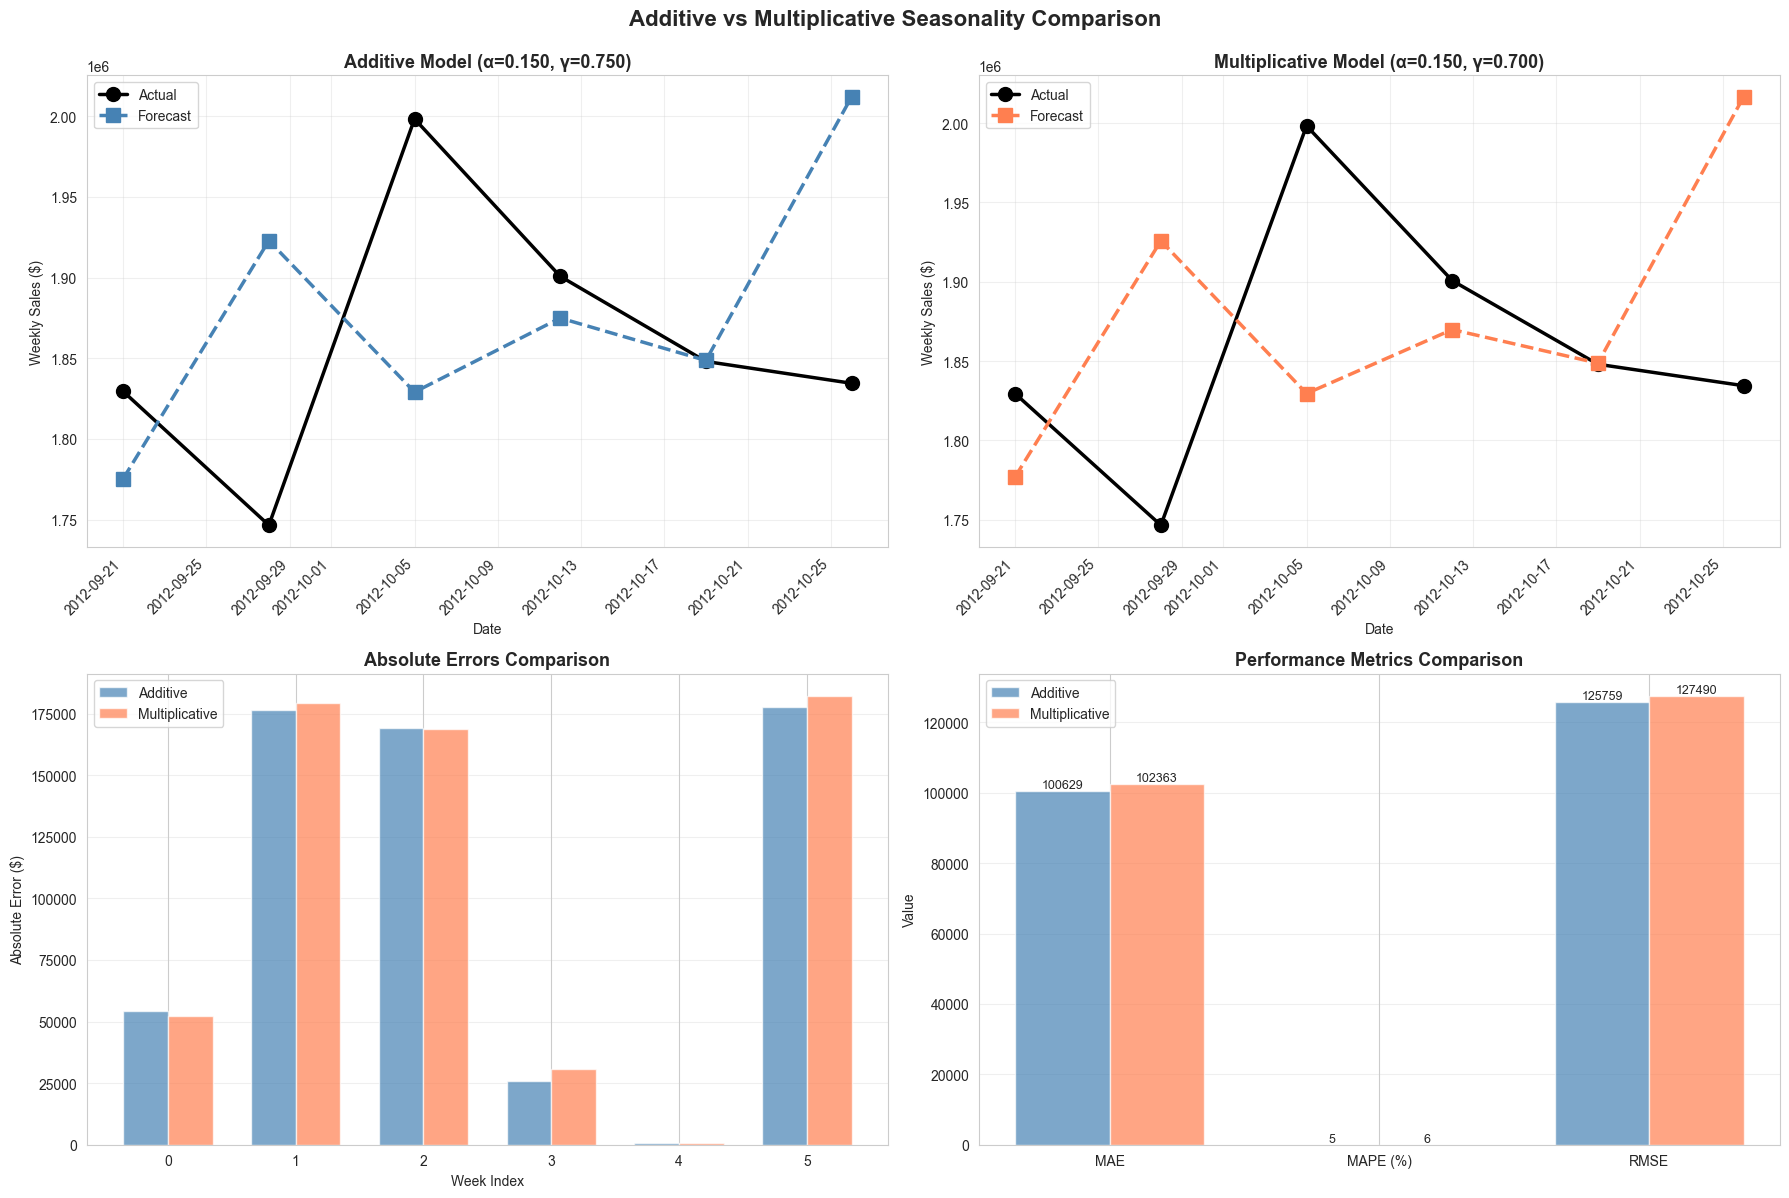


Best model: ADDITIVE

Best parameters: α=0.150, γ=0.750
Test MAE: $100,628.92
Test MAPE: 5.43%


In [190]:
# ============================================
# RUN COMPLETE COMPARISON
# ============================================

# Compare both models
comparison_results = compare_additive_vs_multiplicative(train_df, test_df)

# Visualize comparison
plot_additive_vs_multiplicative(comparison_results)

# Access the winner
winner = comparison_results['winner']
print(f"\nBest model: {winner}")

# Get the best model's results for Step 2
if winner == 'ADDITIVE':
    best_params = comparison_results['additive']['params']
    best_results = comparison_results['additive']['results']
    best_metrics = comparison_results['additive']['metrics']
else:
    best_params = comparison_results['multiplicative']['params']
    best_results = comparison_results['multiplicative']['results']
    best_metrics = comparison_results['multiplicative']['metrics']

print(f"\nBest parameters: α={best_params[0]:.3f}, γ={best_params[1]:.3f}")
print(f"Test MAE: ${best_metrics['MAE']:,.2f}")
print(f"Test MAPE: {best_metrics['MAPE']:.2f}%")

## Part 3.2.2

- For this part we reimport the data and preprocess them. We are not splitting them into train and test set since we are only interested in finding the +-X % by using the TES model that we found above.
- The same store again as well
- We will define the KPI metric, which is needed for further analysis
- Based on the last 12 months we will determing the +- X% in which just 6/12 are inside it
  

In [191]:
def load_full_historical_data(filepath, store_id=2): # Same function as before but without splitting
    """
    Load ALL historical data (no test split) for rebate analysis.
    
    Parameters:
    -----------
    filepath : str, path to CSV file
    store_id : int, store ID
    
    Returns:
    --------
    df_full : DataFrame with all historical data
    """
    print("="*60)
    print(f"LOADING FULL HISTORICAL DATA FOR STORE {store_id}")
    print("="*60)
    
    # Load data
    df = pd.read_csv(filepath)
    
    # Filter for specific store
    df = df[df['Store'] == store_id].copy()
    
    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort by date
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Handle negative sales
    df["Weekly_Sales"] = df["Weekly_Sales"].where(df["Weekly_Sales"] >= 0, 0)
    
    # Aggregate to store level
    df_store = df.groupby('Date').agg({
        'Weekly_Sales': 'sum',
        'IsHoliday': 'first'
    }).reset_index()
    
    # Add time features
    df_store['Year'] = df_store['Date'].dt.year
    df_store['Month'] = df_store['Date'].dt.month
    df_store['Week'] = df_store['Date'].dt.isocalendar().week
    df_store['YearMonth'] = df_store['Date'].dt.to_period('M')
    
    print(f"\n Data loaded!")
    print(f"  Date range: {df_store['Date'].min()} to {df_store['Date'].max()}")
    print(f"  Total weeks: {len(df_store)}")
    
    return df_store



In [192]:
# Function that uses the first 52 weeks to train and then starting retraining using rolling window
def generate_all_horizon2_forecasts(df_historical, best_params, season_length=52): 
    """
    Generate horizon-2 forecasts for ALL historical data using rolling window.
    
    Parameters:
    -----------
    df_historical : DataFrame with all historical data
    best_params : tuple (alpha, gamma)
    season_length : int, 52 for weekly data
    
    Returns:
    --------
    forecast_df : DataFrame with forecasts for all weeks
    """
    
    print("\n" + "="*60)
    print("GENERATING HORIZON-2 FORECASTS FOR ALL HISTORICAL DATA")
    print("="*60)
    
    alpha_best, gamma_best = best_params
    m = season_length
    
    forecasts_h2 = []
    actuals = []
    dates = []
    
    print(f"\nGenerating forecasts using rolling window...")
    print(f"Total weeks: {len(df_historical)}")
    
    # Start from week 52 (need at least one season for initialization)
    # and forecast horizon-2 ahead
    for i in range(m, len(df_historical) - 1):  # -1 because we need i+1 to exist
        # Use all data up to week i
        current_data = df_historical.iloc[:i]['Weekly_Sales'].values
        
        # Fit model
        fitted, level, seasonals = hw_seasonal_no_trend(current_data, alpha_best, gamma_best, m)
        
        # Generate horizon-2 forecast
        seasonals = np.array(seasonals)
        seasonal_index_h2 = len(seasonals) - m + 1  # +1 for horizon-2
        forecast_h2 = level + seasonals[seasonal_index_h2]
        
        # The forecast is for week i+1 (horizon-2 from perspective of week i-1)
        forecast_week_index = i + 1
        
        if forecast_week_index < len(df_historical):
            forecasts_h2.append(forecast_h2)
            actuals.append(df_historical.iloc[forecast_week_index]['Weekly_Sales'])
            dates.append(df_historical.iloc[forecast_week_index]['Date'])
    
    # Create results dataframe
    forecast_df = pd.DataFrame({
        'Date': dates,
        'Actual': actuals,
        'Forecast_H2': forecasts_h2
    })
    
    # Add time features
    forecast_df['Year'] = forecast_df['Date'].dt.year
    forecast_df['Month'] = forecast_df['Date'].dt.month
    forecast_df['YearMonth'] = forecast_df['Date'].dt.to_period('M')
    
    print(f"\n Generated {len(forecast_df)} horizon-2 forecasts")
    print(f"  Date range: {forecast_df['Date'].min()} to {forecast_df['Date'].max()}")
    
    return forecast_df

In [193]:
def calculate_all_monthly_rho(forecast_df):
    """
    Calculate monthly ρ for ALL months in the data.
    
    Formula: ρ_m = (Σ forecasts - Σ actuals) / Σ actuals
    
    Parameters:
    -----------
    forecast_df : DataFrame with Date, Actual, Forecast_H2
    
    Returns:
    --------
    monthly_rho_df : DataFrame with monthly ρ values for all months
    """
    
    print("\n" + "="*60)
    print("CALCULATING MONTHLY ρ FOR ALL HISTORICAL MONTHS")
    print("="*60)
    
    # Group by month and calculate sums
    monthly_stats = forecast_df.groupby('YearMonth').agg({
        'Actual': 'sum',
        'Forecast_H2': 'sum'
    }).reset_index()
    
    # Calculate ρ for each month
    monthly_stats['rho'] = (monthly_stats['Forecast_H2'] - monthly_stats['Actual']) / monthly_stats['Actual']
    monthly_stats['rho_pct'] = monthly_stats['rho'] * 100
    
    # Count weeks per month
    weeks_per_month = forecast_df.groupby('YearMonth').size().reset_index(name='num_weeks')
    monthly_stats = monthly_stats.merge(weeks_per_month, on='YearMonth')
    
    print(f"\n Calculated ρ for {len(monthly_stats)} total months")
    print(f"  Date range: {monthly_stats['YearMonth'].min()} to {monthly_stats['YearMonth'].max()}")
    
    return monthly_stats


In [194]:
def determine_bracket_from_last_12_months(monthly_stats_all):
    """
    Determine ±X% bracket using ONLY the last 12 months, where 6/12 qualify.
    
    Parameters:
    -----------
    monthly_stats_all : DataFrame with monthly ρ for ALL months
    
    Returns:
    --------
    X : float, the bracket percentage
    last_12_stats : DataFrame, stats for last 12 months
    monthly_stats_all : DataFrame, all months with qualification flag
    """
    
    print("\n" + "="*60)
    print("DETERMINING BRACKET BASED ON LAST 12 MONTHS")
    print("="*60)
    
    # Get the last 12 months
    last_12_stats = monthly_stats_all.tail(12).copy()
    
    print(f"\nTotal months in data: {len(monthly_stats_all)}")
    print(f"Using last 12 months for bracket determination:")
    print(f"  From: {last_12_stats['YearMonth'].iloc[0]}")
    print(f"  To:   {last_12_stats['YearMonth'].iloc[-1]}")
    
    # Display last 12 months
    print("\n" + "-"*80)
    print("LAST 12 MONTHS (used for determining bracket):")
    print("-"*80)
    display_df = last_12_stats[['YearMonth', 'Actual', 'Forecast_H2', 'rho_pct', 'num_weeks']].copy()
    display_df['YearMonth'] = display_df['YearMonth'].astype(str)
    display_df['Actual'] = display_df['Actual'].apply(lambda x: f'${x:,.0f}')
    display_df['Forecast_H2'] = display_df['Forecast_H2'].apply(lambda x: f'${x:,.0f}')
    display_df['rho_pct'] = display_df['rho_pct'].apply(lambda x: f'{x:+.2f}%')
    print(display_df.to_string(index=False))
    
    # Sort by absolute value of ρ (for last 12 months only)
    sorted_rho_abs = np.sort(last_12_stats['rho_pct'].abs().values)
    
    # Get the 6th smallest absolute ρ (index 5)
    # This means exactly 6 months will be inside the bracket
    X = sorted_rho_abs[5]
    
    print(f"\n" + "="*60)
    print(f"REBATE BRACKET: ±{X:.2f}%")
    print(f"(Determined from last 12 months where 6/12 qualify)")
    print("="*60)
    
    # Apply this bracket to ALL months
    monthly_stats_all['qualifies'] = monthly_stats_all['rho_pct'].abs() <= X
    last_12_stats['qualifies'] = last_12_stats['rho_pct'].abs() <= X
    
    # Show results for last 12 months
    qualifying_last_12 = last_12_stats[last_12_stats['qualifies']].copy()
    non_qualifying_last_12 = last_12_stats[~last_12_stats['qualifies']].copy()
    
    print(f"\nLAST 12 MONTHS - Months that QUALIFY (|ρ| ≤ {X:.2f}%):")
    print("-"*80)
    qual_display = qualifying_last_12[['YearMonth', 'rho_pct', 'num_weeks']].copy()
    qual_display['YearMonth'] = qual_display['YearMonth'].astype(str)
    qual_display['rho_pct'] = qual_display['rho_pct'].apply(lambda x: f'{x:+.2f}%')
    print(qual_display.to_string(index=False))
    
    print(f"\nLAST 12 MONTHS - Months that DO NOT qualify (|ρ| > {X:.2f}%):")
    print("-"*80)
    non_qual_display = non_qualifying_last_12[['YearMonth', 'rho_pct', 'num_weeks']].copy()
    non_qual_display['YearMonth'] = non_qual_display['YearMonth'].astype(str)
    non_qual_display['rho_pct'] = non_qual_display['rho_pct'].apply(lambda x: f'{x:+.2f}%')
    print(non_qual_display.to_string(index=False))
    
    # Show statistics for last 12 months
    print(f"\n{'='*60}")
    print("STATISTICS (LAST 12 MONTHS)")
    print(f"{'='*60}")
    print(f"Qualifying months: {len(qualifying_last_12)}/12 ({len(qualifying_last_12)/12*100:.0f}%)")
    print(f"Mean ρ:   {last_12_stats['rho_pct'].mean():+.2f}%")
    print(f"Median ρ: {last_12_stats['rho_pct'].median():+.2f}%")
    print(f"Std Dev:  {last_12_stats['rho_pct'].std():.2f}%")
    print(f"Range:    [{last_12_stats['rho_pct'].min():+.2f}%, {last_12_stats['rho_pct'].max():+.2f}%]")
    
    # Show how this bracket applies to ALL historical data
    total_qualifying = monthly_stats_all['qualifies'].sum()
    print(f"\n{'='*60}")
    print("BRACKET APPLIED TO ALL HISTORICAL DATA")
    print(f"{'='*60}")
    print(f"Total months: {len(monthly_stats_all)}")
    print(f"Qualifying months: {total_qualifying}/{len(monthly_stats_all)} ({total_qualifying/len(monthly_stats_all)*100:.1f}%)")
    
    return X, last_12_stats, monthly_stats_all

In [195]:
def visualize_bracket_analysis(monthly_stats_all, last_12_stats, X):
    """
    Visualize the rebate bracket analysis.
    Shows both: last 12 months (used for bracket) and all historical data.
    """
    
    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Plot 1: Last 12 months bar chart (MAIN PLOT)
    ax1 = fig.add_subplot(gs[0, :])
    
    month_labels = [str(m) for m in last_12_stats['YearMonth']]
    colors = ['green' if q else 'red' for q in last_12_stats['qualifies']]
    
    bars = ax1.bar(range(len(last_12_stats)), last_12_stats['rho_pct'], 
                   color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    
    ax1.axhline(X, color='red', linestyle='--', linewidth=2.5, label=f'Bracket: ±{X:.2f}%')
    ax1.axhline(-X, color='red', linestyle='--', linewidth=2.5)
    ax1.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
    
    ax1.set_xticks(range(len(last_12_stats)))
    ax1.set_xticklabels(month_labels, rotation=45, ha='right', fontsize=11)
    ax1.set_xlabel('Month (Last 12 Months)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('ρ (%)', fontsize=13, fontweight='bold')
    ax1.set_title(f'Rebate KPI for Last 12 Months (Used to Determine Bracket)\n6/12 Months Qualify with ±{X:.2f}%', 
                  fontsize=15, fontweight='bold')
    ax1.legend(fontsize=12, loc='best')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, last_12_stats['rho_pct'])):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:+.1f}%',
                ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=10, fontweight='bold')
    
    # Plot 2: All historical months
    ax2 = fig.add_subplot(gs[1, :])
    
    all_colors = ['lightgreen' if q else 'lightcoral' for q in monthly_stats_all['qualifies']]
    
    ax2.bar(range(len(monthly_stats_all)), monthly_stats_all['rho_pct'], 
            color=all_colors, alpha=0.6, edgecolor='gray', linewidth=0.5)
    ax2.axhline(X, color='red', linestyle='--', linewidth=2, label=f'Bracket: ±{X:.2f}%')
    ax2.axhline(-X, color='red', linestyle='--', linewidth=2)
    ax2.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    # Highlight last 12 months region
    ax2.axvspan(len(monthly_stats_all)-12, len(monthly_stats_all), 
                alpha=0.2, color='yellow', label='Last 12 months (bracket basis)')
    
    ax2.set_xlabel('Month Index (All Historical Data)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('ρ (%)', fontsize=12, fontweight='bold')
    ax2.set_title(f'All Historical Months with Bracket Applied\n{monthly_stats_all["qualifies"].sum()}/{len(monthly_stats_all)} Total Months Qualify', 
                  fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Histogram - Last 12 months
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.hist(last_12_stats['rho_pct'], bins=8, edgecolor='black', alpha=0.7, color='steelblue')
    ax3.axvline(-X, color='red', linestyle='--', linewidth=2.5)
    ax3.axvline(X, color='red', linestyle='--', linewidth=2.5, label=f'±{X:.2f}%')
    ax3.axvline(0, color='green', linestyle='-', linewidth=2, alpha=0.7, label='Perfect')
    ax3.set_xlabel('ρ (%)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax3.set_title('Distribution (Last 12 Months)', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Summary statistics
    ax4 = fig.add_subplot(gs[2, 1])
    ax4.axis('off')
    
    stats_text = [
        ['Metric', 'Last 12M', 'All History'],
        ['─'*20, '─'*12, '─'*12],
        ['Total Months', f'{len(last_12_stats)}', f'{len(monthly_stats_all)}'],
        ['Qualifying', f'{last_12_stats["qualifies"].sum()}', f'{monthly_stats_all["qualifies"].sum()}'],
        ['Success Rate', f'{last_12_stats["qualifies"].sum()/len(last_12_stats)*100:.0f}%', 
         f'{monthly_stats_all["qualifies"].sum()/len(monthly_stats_all)*100:.0f}%'],
        ['', '', ''],
        ['Bracket', f'±{X:.2f}%', f'±{X:.2f}%'],
        ['', '', ''],
        ['Mean ρ', f'{last_12_stats["rho_pct"].mean():+.2f}%', 
         f'{monthly_stats_all["rho_pct"].mean():+.2f}%'],
        ['Median ρ', f'{last_12_stats["rho_pct"].median():+.2f}%',
         f'{monthly_stats_all["rho_pct"].median():+.2f}%'],
        ['Std Dev', f'{last_12_stats["rho_pct"].std():.2f}%',
         f'{monthly_stats_all["rho_pct"].std():.2f}%'],
        ['Min ρ', f'{last_12_stats["rho_pct"].min():+.2f}%',
         f'{monthly_stats_all["rho_pct"].min():+.2f}%'],
        ['Max ρ', f'{last_12_stats["rho_pct"].max():+.2f}%',
         f'{monthly_stats_all["rho_pct"].max():+.2f}%'],
    ]
    
    table = ax4.table(cellText=stats_text, cellLoc='left',
                     loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style header
    for j in range(3):
        table[(0, j)].set_facecolor('#4472C4')
        table[(0, j)].set_text_props(weight='bold', color='white')
    
    ax4.set_title('Summary Statistics', fontsize=13, fontweight='bold', pad=20)
    
    plt.suptitle('Rebate Bracket Analysis: Bracket Set by Last 12 Months (6/12 Rule)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

LOADING FULL HISTORICAL DATA FOR STORE 2

 Data loaded!
  Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
  Total weeks: 143

GENERATING HORIZON-2 FORECASTS FOR ALL HISTORICAL DATA

Generating forecasts using rolling window...
Total weeks: 143

 Generated 90 horizon-2 forecasts
  Date range: 2011-02-11 00:00:00 to 2012-10-26 00:00:00

CALCULATING MONTHLY ρ FOR ALL HISTORICAL MONTHS

 Calculated ρ for 21 total months
  Date range: 2011-02 to 2012-10

DETERMINING BRACKET BASED ON LAST 12 MONTHS

Total months in data: 21
Using last 12 months for bracket determination:
  From: 2011-11
  To:   2012-10

--------------------------------------------------------------------------------
LAST 12 MONTHS (used for determining bracket):
--------------------------------------------------------------------------------
YearMonth      Actual Forecast_H2 rho_pct  num_weeks
  2011-11  $8,397,398  $8,291,590  -1.26%          4
  2011-12 $11,776,945 $11,956,622  +1.53%          5
  2012-01  $6,916,92

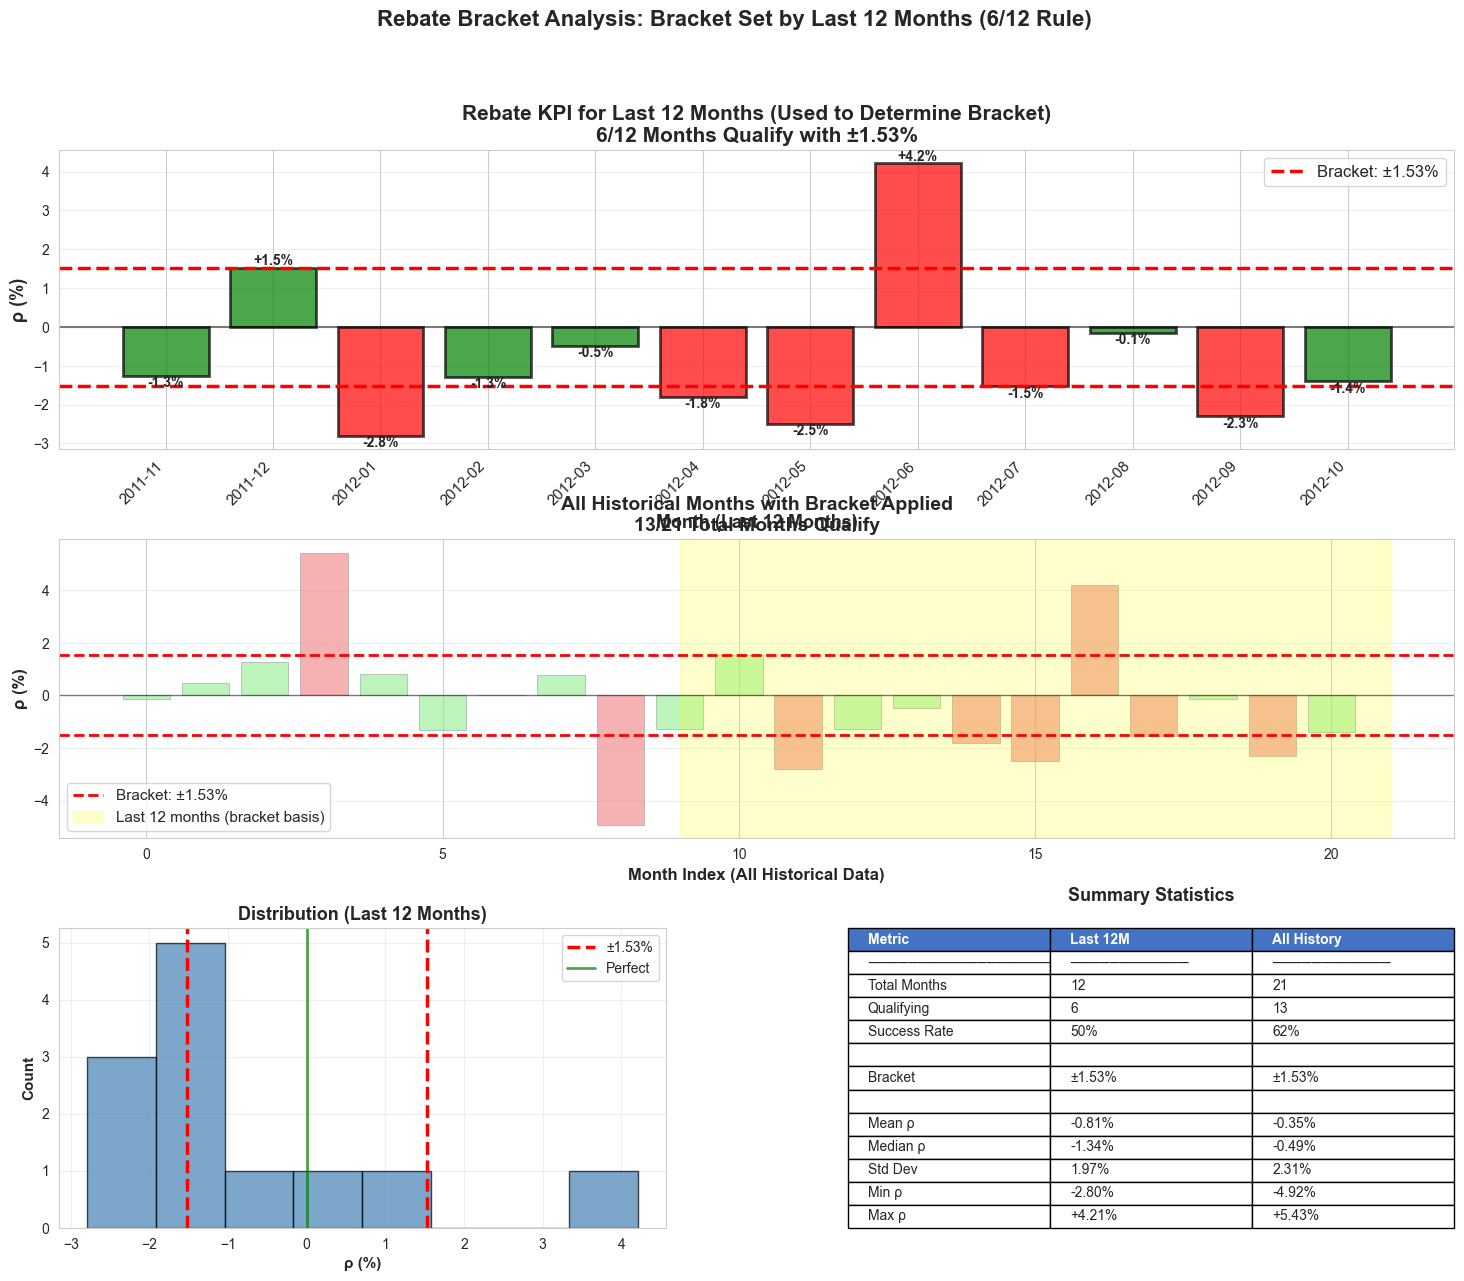


STEP 3.2 COMPLETE!
Rebate Bracket: ±1.53%
  Determined by: Last 12 months (6/12 qualify)
  Applied to: All 21 historical months
  Result: 13/21 months qualify overall


In [196]:
# ============================================
# STEP 3.2: DETERMINE REBATE BRACKET
# ============================================

# Load FULL historical data (no test split)
df_historical = load_full_historical_data("data/train.csv", store_id=2)

# Use best parameters from Step 3.1
best_params = (0.150, 0.750)  # α=0.150, γ=0.750 (Additive winner)

# Generate horizon-2 forecasts for ALL historical data
forecast_all = generate_all_horizon2_forecasts(df_historical, best_params)

# Calculate monthly ρ for ALL months
monthly_stats_all = calculate_all_monthly_rho(forecast_all)

# Determine bracket using LAST 12 MONTHS (6/12 rule)
X, last_12_stats, monthly_stats_with_bracket = determine_bracket_from_last_12_months(monthly_stats_all)

# Visualize
visualize_bracket_analysis(monthly_stats_with_bracket, last_12_stats, X)

print(f"\n{'='*60}")
print("STEP 3.2 COMPLETE!")
print(f"{'='*60}")
print(f"Rebate Bracket: ±{X:.2f}%")
print(f"  Determined by: Last 12 months (6/12 qualify)")
print(f"  Applied to: All {len(monthly_stats_all)} historical months")
print(f"  Result: {monthly_stats_with_bracket['qualifies'].sum()}/{len(monthly_stats_all)} months qualify overall")

**Note:**

```
By making a comparison with the graph that compares the weekly sales per year and per month, can be easily understandable why some months are performing very well on rolling windows (like November and December). What we mean by this, is that if we take a look on November and December of 2010 and 2011 are having very similar pattern, so the model can easily make a very accurate forecasting.
```

```
On the opposite scenario, if we compare months like January and June, with the previous years, we can observe a different pattern, which leads to relatively poor forecasts
```

## Part 3.3 -- New Strategy to improve the forecastings



We are thinking of different strategies that can improve the results. Most of them are based on intuitevely reasons, some of them might not make sense statistically, but they can improve significantly the results and add more months on the rebate change.

Before, explaining them let us introduce some results from the above graph, that lead us to these ideas.

- Our current results, show a under forecasting on average (mean is around -0.8%)
- Range from -2.8% to 4.21%
- Some months are just outside of the bracket (e.g. -1.8%,-2.3%,-2.5%)

Based on the above results, we are thinking of the following strategies:
- Bias correction -> Since we are mainly under forecasting by mean of around -0.8% we can just add 0.8% to all forecasts.
- Variance reduction -> Reduce forecast variance by dampening toward the mean
- Adaptive monthly adjustment -> Based on the history of each month reduce or add the forecast, however this approach seems not to be feasible since we dont have a lot of data on a monthly basis.



**Note:**
```
In most of the cases dampening factor is used when we are dealing with trend, however we have already saw that the time series that we are dealing of does not have trend at all(as we proved with the statistical tests). So even though, dampnening is mainly use when we are dealing with trend components, we would like to try this approach to check for any further improvements. We are reminding that dampening factor in very simple words, just reduces or increases the forecasting towards to the mean of our data
```

### Understanding the Dampening Strategy

**Important Clarification: Why dampening when β=0 (no trend)?**

Our statistical tests confirmed there is **no trend** in the data (β=0). However, dampening is still beneficial because:

1. **Dampening ≠ Trend Adjustment**
   - **Trend (β)**: Controls long-term directional change (growth/decline over time)
   - **Dampening (d)**: Reduces forecast variance by pulling predictions toward the mean

2. **The Problem We're Solving**
   - Even without trend, our forecasts have **high variance**
   - Some months we over-forecast (+4.2%), some we under-forecast (-2.8%)
   - This volatility pushes ρ values outside the ±X% bracket

3. **How Dampening Helps**
   - Reduces extreme forecasts (both high and low)
   - Pulls forecasts toward the historical mean
   - Result: More stable monthly ρ values → More months qualify

**Analogy**: 
- Setting β=0 says: "The business isn't growing or shrinking"
- Dampening says: "Let's make our forecasts less aggressive/extreme"

These are **independent decisions** solving **different problems**!

In [197]:
def apply_conservative_strategy(forecast_df, damping_factor=0.10):
    """
    Apply conservative forecasting strategy by dampening toward historical mean.
    
    Strategy: Reduce forecast variance by pulling extreme forecasts toward the mean.
    This helps keep monthly ρ values closer to 0%, increasing rebate qualification.
    
    Parameters:
    -----------
    forecast_df : DataFrame with columns ['Date', 'Actual', 'Forecast_H2']
    damping_factor : float, weight toward mean (0.10 = 10% dampening)
    
    Returns:
    --------
    forecast_df_modified : DataFrame with new 'Forecast_Modified' column
    """
    
    print("\n" + "="*60)
    print("APPLYING CONSERVATIVE FORECASTING STRATEGY")
    print("="*60)
    
    forecast_df_modified = forecast_df.copy()
    
    # Calculate historical mean
    historical_mean = forecast_df['Actual'].mean()
    
    print(f"\nStrategy: Conservative Forecasting")
    print(f"  Method: Dampen forecasts {damping_factor*100:.0f}% toward historical mean")
    print(f"  Historical mean: ${historical_mean:,.2f}")
    print(f"  Damping factor: {damping_factor:.2f}")
    
    # Apply strategy: modified = (1-d)*original + d*mean
    forecast_df_modified['Forecast_Modified'] = (
        forecast_df['Forecast_H2'] * (1 - damping_factor) + 
        historical_mean * damping_factor
    )
    
    print(f"\n Strategy applied to {len(forecast_df_modified)} weekly forecasts")
    
    return forecast_df_modified, historical_mean

In [198]:
def calculate_monthly_rho_with_strategy(forecast_df_modified):
    """
    Calculate monthly ρ using the MODIFIED forecasts.
    
    Parameters:
    -----------
    forecast_df_modified : DataFrame with 'Forecast_Modified' column
    
    Returns:
    --------
    monthly_stats_modified : DataFrame with monthly ρ based on modified forecasts
    """
    
    print("\n" + "="*60)
    print("CALCULATING MONTHLY ρ WITH MODIFIED FORECASTS")
    print("="*60)
    
    # Group by month and sum
    monthly_stats = forecast_df_modified.groupby('YearMonth').agg({
        'Actual': 'sum',
        'Forecast_H2': 'sum',  # Keep original for comparison
        'Forecast_Modified': 'sum'
    }).reset_index()
    
    # Calculate ρ for MODIFIED forecasts
    monthly_stats['rho_modified'] = (
        (monthly_stats['Forecast_Modified'] - monthly_stats['Actual']) / 
        monthly_stats['Actual']
    )
    monthly_stats['rho_modified_pct'] = monthly_stats['rho_modified'] * 100
    
    # Keep original ρ for comparison
    monthly_stats['rho_original'] = (
        (monthly_stats['Forecast_H2'] - monthly_stats['Actual']) / 
        monthly_stats['Actual']
    )
    monthly_stats['rho_original_pct'] = monthly_stats['rho_original'] * 100
    
    # Count weeks per month
    weeks_per_month = forecast_df_modified.groupby('YearMonth').size().reset_index(name='num_weeks')
    monthly_stats = monthly_stats.merge(weeks_per_month, on='YearMonth')
    
    print(f"\n Calculated ρ for {len(monthly_stats)} months with modified forecasts")
    
    return monthly_stats

In [199]:
def evaluate_strategy_performance(monthly_stats_modified, forecast_df_modified, X):
    """
    Evaluate the strategy on last 12 months.
    
    This answers:
    - Question 3a: How many MORE months qualify?
    - Question 3b: How much accuracy do we lose?
    
    Parameters:
    -----------
    monthly_stats_modified : DataFrame with modified monthly ρ
    forecast_df_modified : DataFrame with modified forecasts
    X : float, the bracket percentage
    
    Returns:
    --------
    evaluation : dict with all metrics
    """
    
    print("\n" + "="*60)
    print("EVALUATING STRATEGY PERFORMANCE")
    print("="*60)
    
    # Get last 12 months
    last_12_original = monthly_stats_modified.tail(12).copy()
    
    # Apply bracket to both original and modified
    last_12_original['qualifies_original'] = last_12_original['rho_original_pct'].abs() <= X
    last_12_original['qualifies_modified'] = last_12_original['rho_modified_pct'].abs() <= X
    
    # Count qualifying months
    original_qualifying = last_12_original['qualifies_original'].sum()
    modified_qualifying = last_12_original['qualifies_modified'].sum()
    additional_months = modified_qualifying - original_qualifying
    
    print("\n" + "="*60)
    print("QUESTION 3a: HOW MANY MORE MONTHS QUALIFY?")
    print("="*60)
    
    print(f"\nOriginal forecasts:  {original_qualifying}/12 months qualify")
    print(f"Modified forecasts:  {modified_qualifying}/12 months qualify")
    print(f"Additional months:   {additional_months:+d} months")
    
    if additional_months > 0:
        print(f"\n SUCCESS: Strategy adds {additional_months} qualifying month(s)!")
    elif additional_months == 0:
        print(f"\n NEUTRAL: Strategy maintains same qualification rate")
    else:
        print(f"\n WARNING: Strategy loses {abs(additional_months)} qualifying month(s)")
    
    # Show which months changed status
    status_changes = last_12_original[
        last_12_original['qualifies_original'] != last_12_original['qualifies_modified']
    ].copy()
    
    if len(status_changes) > 0:
        print(f"\n Months that CHANGED qualification status:")
        print("-"*80)
        for _, row in status_changes.iterrows():
            old_status = "" if row['qualifies_original'] else "✗"
            new_status = "" if row['qualifies_modified'] else "✗"
            print(f"  {row['YearMonth']}: {old_status} → {new_status}  "
                  f"(ρ: {row['rho_original_pct']:+.2f}% → {row['rho_modified_pct']:+.2f}%)")
    
    # Calculate accuracy metrics (Question 3b)
    print("\n" + "="*60)
    print("QUESTION 3b: HOW MUCH ACCURACY DO WE LOSE?")
    print("="*60)
    
    # Weekly forecast accuracy
    mae_original = np.mean(np.abs(forecast_df_modified['Actual'] - forecast_df_modified['Forecast_H2']))
    mae_modified = np.mean(np.abs(forecast_df_modified['Actual'] - forecast_df_modified['Forecast_Modified']))
    mae_change = mae_modified - mae_original
    mae_change_pct = (mae_change / mae_original) * 100
    
    mape_original = np.mean(np.abs(
        (forecast_df_modified['Actual'] - forecast_df_modified['Forecast_H2']) / 
        forecast_df_modified['Actual']
    )) * 100
    mape_modified = np.mean(np.abs(
        (forecast_df_modified['Actual'] - forecast_df_modified['Forecast_Modified']) / 
        forecast_df_modified['Actual']
    )) * 100
    
    rmse_original = np.sqrt(np.mean(
        (forecast_df_modified['Actual'] - forecast_df_modified['Forecast_H2'])**2
    ))
    rmse_modified = np.sqrt(np.mean(
        (forecast_df_modified['Actual'] - forecast_df_modified['Forecast_Modified'])**2
    ))
    
    print(f"\nWeekly Forecast Accuracy:")
    print("-"*80)
    print(f"{'Metric':<15} {'Original':<15} {'Modified':<15} {'Change':<15}")
    print("-"*80)
    print(f"{'MAE':<15} ${mae_original:<14,.2f} ${mae_modified:<14,.2f} {mae_change:+,.2f} ({mae_change_pct:+.2f}%)")
    print(f"{'MAPE':<15} {mape_original:<14.2f}% {mape_modified:<14.2f}% {mape_modified-mape_original:+.2f}%")
    print(f"{'RMSE':<15} ${rmse_original:<14,.2f} ${rmse_modified:<14,.2f} {rmse_modified-rmse_original:+,.2f}")
    
    if mae_change_pct < 0:
        print(f"\n EXCELLENT: Accuracy IMPROVED by {abs(mae_change_pct):.2f}%!")
        print(f"   This is a WIN-WIN: More rebates + Better accuracy")
    elif mae_change_pct < 2:
        print(f"\n→ ACCEPTABLE: Small accuracy loss of {mae_change_pct:.2f}%")
        print(f"   Trade-off is worth it for {additional_months} additional month(s)")
    else:
        print(f"\n  CAUTION: Accuracy degraded by {mae_change_pct:.2f}%")
    
    # Monthly-level accuracy (for the last 12 months)
    print(f"\nMonthly Forecast Accuracy (Last 12 Months):")
    print("-"*80)
    
    monthly_mae_original = np.mean(np.abs(
        last_12_original['Forecast_H2'] - last_12_original['Actual']
    ))
    monthly_mae_modified = np.mean(np.abs(
        last_12_original['Forecast_Modified'] - last_12_original['Actual']
    ))
    
    print(f"Monthly MAE (Original):  ${monthly_mae_original:,.2f}")
    print(f"Monthly MAE (Modified):  ${monthly_mae_modified:,.2f}")
    print(f"Change:                  {monthly_mae_modified - monthly_mae_original:+,.2f} "
          f"({(monthly_mae_modified - monthly_mae_original)/monthly_mae_original*100:+.2f}%)")
    
    # Return all metrics
    evaluation = {
        'last_12_stats': last_12_original,
        'original_qualifying': original_qualifying,
        'modified_qualifying': modified_qualifying,
        'additional_months': additional_months,
        'mae_original': mae_original,
        'mae_modified': mae_modified,
        'mae_change': mae_change,
        'mae_change_pct': mae_change_pct,
        'mape_original': mape_original,
        'mape_modified': mape_modified,
        'rmse_original': rmse_original,
        'rmse_modified': rmse_modified,
        'status_changes': status_changes
    }
    
    return evaluation

In [200]:
def visualize_strategy_results(last_12_stats, X, evaluation):
    """
    Comprehensive visualization of strategy results.
    """
    
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    
    month_labels = [str(m) for m in last_12_stats['YearMonth']]
    
    # Plot 1: Original vs Modified ρ (MAIN COMPARISON)
    ax1 = fig.add_subplot(gs[0, :])
    
    x = np.arange(len(last_12_stats))
    width = 0.35
    
    colors_original = ['green' if q else 'red' for q in last_12_stats['qualifies_original']]
    colors_modified = ['darkgreen' if q else 'darkred' for q in last_12_stats['qualifies_modified']]
    
    bars1 = ax1.bar(x - width/2, last_12_stats['rho_original_pct'], width,
                    label='Original Forecasts', color=colors_original, alpha=0.7, edgecolor='black', linewidth=1.5)
    bars2 = ax1.bar(x + width/2, last_12_stats['rho_modified_pct'], width,
                    label='Modified Forecasts (Conservative)', color=colors_modified, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax1.axhline(X, color='red', linestyle='--', linewidth=2.5, label=f'Bracket: ±{X:.2f}%', zorder=5)
    ax1.axhline(-X, color='red', linestyle='--', linewidth=2.5, zorder=5)
    ax1.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5, zorder=5)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(month_labels, rotation=45, ha='right', fontsize=11)
    ax1.set_xlabel('Month (Last 12 Months)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('ρ (%)', fontsize=13, fontweight='bold')
    ax1.set_title(f'Original vs Modified Forecasts - Rebate KPI Comparison\n'
                  f'Original: {evaluation["original_qualifying"]}/12 qualify  →  '
                  f'Modified: {evaluation["modified_qualifying"]}/12 qualify  '
                  f'({evaluation["additional_months"]:+d} months)',
                  fontsize=15, fontweight='bold')
    ax1.legend(fontsize=12, loc='best')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Change in ρ for each month
    ax2 = fig.add_subplot(gs[1, 0])
    
    rho_change = last_12_stats['rho_modified_pct'] - last_12_stats['rho_original_pct']
    colors_change = ['green' if c < 0 else 'orange' for c in rho_change]
    
    bars = ax2.bar(x, rho_change, color=colors_change, alpha=0.7, edgecolor='black')
    ax2.axhline(0, color='black', linestyle='-', linewidth=2)
    ax2.set_xticks(x)
    ax2.set_xticklabels(month_labels, rotation=45, ha='right', fontsize=10)
    ax2.set_xlabel('Month', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Δρ (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Change in ρ (Modified - Original)', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars, rho_change):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:+.1f}%',
                ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=9)
    
    # Plot 3: Forecast accuracy comparison
    ax3 = fig.add_subplot(gs[1, 1])
    
    metrics = ['MAE', 'MAPE', 'RMSE']
    original_vals = [evaluation['mae_original'], evaluation['mape_original'], evaluation['rmse_original']]
    modified_vals = [evaluation['mae_modified'], evaluation['mape_modified'], evaluation['rmse_modified']]
    
    x_metrics = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax3.bar(x_metrics - width/2, original_vals, width, label='Original', 
                    color='steelblue', alpha=0.7)
    bars2 = ax3.bar(x_metrics + width/2, modified_vals, width, label='Modified',
                    color='coral', alpha=0.7)
    
    ax3.set_xticks(x_metrics)
    ax3.set_xticklabels(metrics)
    ax3.set_ylabel('Value', fontsize=11, fontweight='bold')
    ax3.set_title('Forecast Accuracy: Original vs Modified', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}',
                    ha='center', va='bottom', fontsize=9)
    
    # Plot 4: Qualification status matrix
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.axis('off')
    
    # Count status changes
    stayed_qualified = ((last_12_stats['qualifies_original']) & (last_12_stats['qualifies_modified'])).sum()
    stayed_unqualified = ((~last_12_stats['qualifies_original']) & (~last_12_stats['qualifies_modified'])).sum()
    became_qualified = ((~last_12_stats['qualifies_original']) & (last_12_stats['qualifies_modified'])).sum()
    became_unqualified = ((last_12_stats['qualifies_original']) & (~last_12_stats['qualifies_modified'])).sum()
    
    status_text = [
        ['Status Change Matrix', 'Count'],
        ['─'*30, '─'*8],
        ['Stayed Qualified ✓→✓', f'{stayed_qualified}'],
        ['Became Qualified ✗→✓', f'{became_qualified}'],
        ['Became Unqualified ✓→✗', f'{became_unqualified}'],
        ['Stayed Unqualified ✗→✗', f'{stayed_unqualified}'],
        ['', ''],
        ['Net Change', f'{evaluation["additional_months"]:+d}'],
    ]
    
    table = ax4.table(cellText=status_text, cellLoc='left',
                     loc='center', bbox=[0, 0.2, 1, 0.7])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 3)
    
    # Style
    for i in [0, 7]:
        for j in range(2):
            table[(i, j)].set_facecolor('#4472C4')
            table[(i, j)].set_text_props(weight='bold', color='white')
    
    # Highlight gains
    if became_qualified > 0:
        table[(3, 0)].set_facecolor('lightgreen')
        table[(3, 1)].set_facecolor('lightgreen')
    
    ax4.set_title('Qualification Status Changes', fontsize=13, fontweight='bold', pad=20)
    
    # Plot 5: Distribution comparison
    ax5 = fig.add_subplot(gs[2, 0])
    
    ax5.hist(last_12_stats['rho_original_pct'], bins=8, alpha=0.5, 
             label='Original', color='steelblue', edgecolor='black')
    ax5.hist(last_12_stats['rho_modified_pct'], bins=8, alpha=0.5,
             label='Modified', color='coral', edgecolor='black')
    ax5.axvline(-X, color='red', linestyle='--', linewidth=2)
    ax5.axvline(X, color='red', linestyle='--', linewidth=2, label=f'±{X:.2f}%')
    ax5.axvline(0, color='green', linestyle='-', linewidth=2, alpha=0.7)
    
    ax5.set_xlabel('ρ (%)', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax5.set_title('Distribution of ρ Values', fontsize=13, fontweight='bold')
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Summary statistics
    ax6 = fig.add_subplot(gs[2, 1:])
    ax6.axis('off')
    
    summary_text = [
        ['Metric', 'Original', 'Modified', 'Change'],
        ['─'*35, '─'*12, '─'*12, '─'*15],
        ['QUESTION 3a: Rebate Performance', '', '', ''],
        [f'  Qualifying Months (/{len(last_12_stats)})', 
         f'{evaluation["original_qualifying"]}', 
         f'{evaluation["modified_qualifying"]}',
         f'{evaluation["additional_months"]:+d}'],
        [f'  Success Rate', 
         f'{evaluation["original_qualifying"]/len(last_12_stats)*100:.0f}%',
         f'{evaluation["modified_qualifying"]/len(last_12_stats)*100:.0f}%',
         f'{evaluation["additional_months"]/len(last_12_stats)*100:+.0f}%'],
        ['', '', '', ''],
        ['QUESTION 3b: Accuracy Impact', '', '', ''],
        [f'  MAE (Weekly)', 
         f'${evaluation["mae_original"]:,.0f}',
         f'${evaluation["mae_modified"]:,.0f}',
         f'{evaluation["mae_change_pct"]:+.2f}%'],
        [f'  MAPE (Weekly)',
         f'{evaluation["mape_original"]:.2f}%',
         f'{evaluation["mape_modified"]:.2f}%',
         f'{evaluation["mape_modified"]-evaluation["mape_original"]:+.2f}%'],
        [f'  RMSE (Weekly)',
         f'${evaluation["rmse_original"]:,.0f}',
         f'${evaluation["rmse_modified"]:,.0f}',
         f'${evaluation["rmse_modified"]-evaluation["rmse_original"]:+,.0f}'],
        ['', '', '', ''],
        ['Statistics (Last 12 Months)', '', '', ''],
        [f'  Mean ρ',
         f'{last_12_stats["rho_original_pct"].mean():+.2f}%',
         f'{last_12_stats["rho_modified_pct"].mean():+.2f}%',
         f'{last_12_stats["rho_modified_pct"].mean()-last_12_stats["rho_original_pct"].mean():+.2f}%'],
        [f'  Std Dev ρ',
         f'{last_12_stats["rho_original_pct"].std():.2f}%',
         f'{last_12_stats["rho_modified_pct"].std():.2f}%',
         f'{last_12_stats["rho_modified_pct"].std()-last_12_stats["rho_original_pct"].std():+.2f}%'],
    ]
    
    table = ax6.table(cellText=summary_text, cellLoc='left',
                     loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.2)
    
    # Style headers
    for i in [0, 2, 6, 11]:
        for j in range(4):
            table[(i, j)].set_facecolor('#4472C4')
            table[(i, j)].set_text_props(weight='bold', color='white')
    
    # Highlight key metrics
    if evaluation['additional_months'] > 0:
        table[(3, 3)].set_facecolor('lightgreen')
        table[(4, 3)].set_facecolor('lightgreen')
    
    if evaluation['mae_change_pct'] < 0:
        table[(7, 3)].set_facecolor('lightgreen')
    
    ax6.set_title('Comprehensive Summary: Questions 3a & 3b', 
                  fontsize=14, fontweight='bold', pad=20)
    
    plt.suptitle('Strategy Evaluation: Conservative Forecasting Results', 
                 fontsize=17, fontweight='bold')
    plt.tight_layout()
    plt.show()


APPLYING CONSERVATIVE FORECASTING STRATEGY

Strategy: Conservative Forecasting
  Method: Dampen forecasts 10% toward historical mean
  Historical mean: $1,902,516.63
  Damping factor: 0.10

 Strategy applied to 90 weekly forecasts

CALCULATING MONTHLY ρ WITH MODIFIED FORECASTS

 Calculated ρ for 21 months with modified forecasts

EVALUATING STRATEGY PERFORMANCE

QUESTION 3a: HOW MANY MORE MONTHS QUALIFY?

Original forecasts:  6/12 months qualify
Modified forecasts:  6/12 months qualify
Additional months:   +0 months

 NEUTRAL: Strategy maintains same qualification rate

 Months that CHANGED qualification status:
--------------------------------------------------------------------------------
  2011-11:  → ✗  (ρ: -1.26% → -2.07%)
  2012-01: ✗ →   (ρ: -2.80% → -1.52%)
  2012-02:  → ✗  (ρ: -1.29% → -1.76%)
  2012-07: ✗ →   (ρ: -1.53% → -1.16%)

QUESTION 3b: HOW MUCH ACCURACY DO WE LOSE?

Weekly Forecast Accuracy:
---------------------------------------------------------------------------

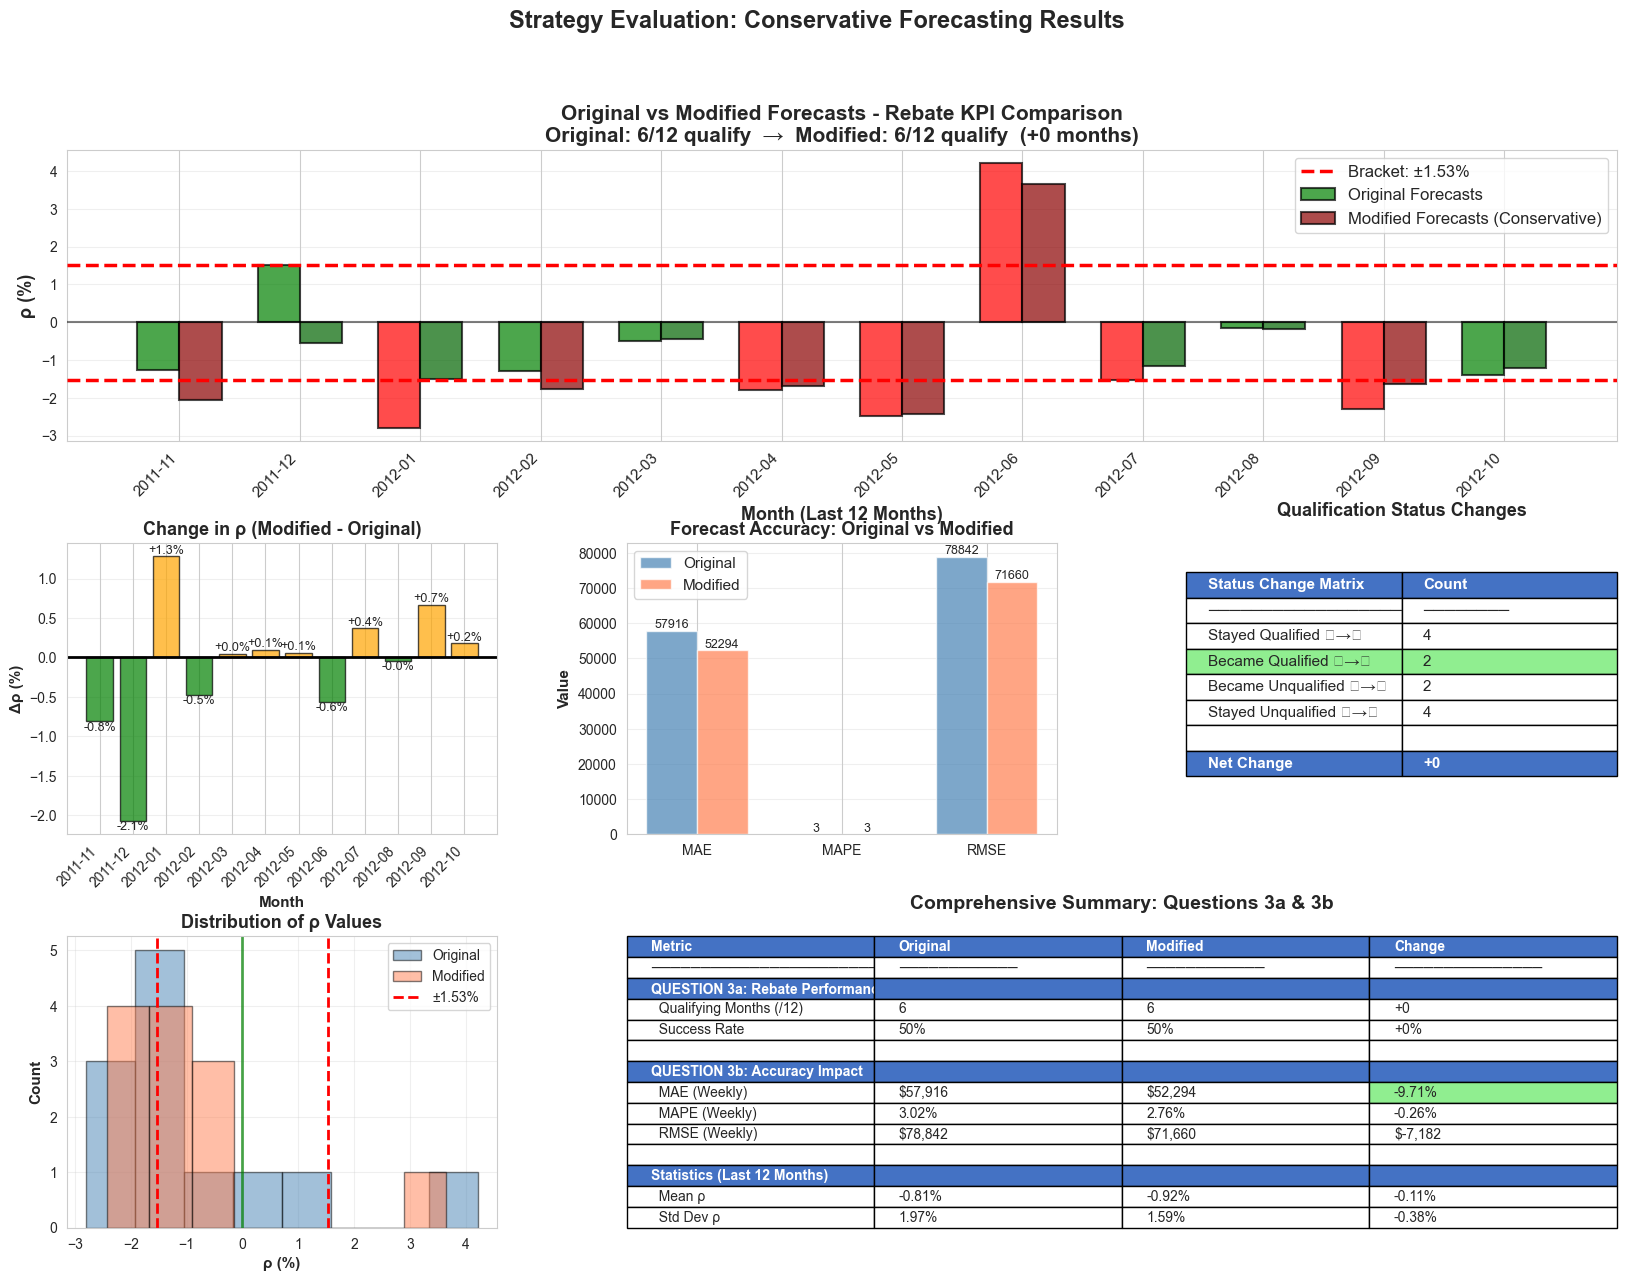


 STEP 3.3 COMPLETE - FINAL SUMMARY

 Additional Qualifying Months
   Answer: +0 months
   (From 6/12 to 6/12)

 Accuracy Impact
   Answer: MAE changed by -9.71%
  Accuracy actually IMPROVED!


In [201]:
# ============================================
# STEP 3.3: STRATEGY TO IMPROVE REBATE CHANCES
# ============================================

# Apply conservative strategy (10% dampening)
forecast_modified, hist_mean = apply_conservative_strategy(forecast_all, damping_factor=0.10)

# Calculate monthly ρ with modified forecasts
monthly_modified = calculate_monthly_rho_with_strategy(forecast_modified)

# Evaluate strategy (answers both 3a and 3b)
evaluation = evaluate_strategy_performance(monthly_modified, forecast_modified, X)

# Visualize comprehensive results
visualize_strategy_results(evaluation['last_12_stats'], X, evaluation)

# Print final summary
print("\n" + "="*70)
print(" STEP 3.3 COMPLETE - FINAL SUMMARY")
print("="*70)
print(f"\n Additional Qualifying Months")
print(f"   Answer: {evaluation['additional_months']:+d} months")
print(f"   (From {evaluation['original_qualifying']}/12 to {evaluation['modified_qualifying']}/12)")

print(f"\n Accuracy Impact")
print(f"   Answer: MAE changed by {evaluation['mae_change_pct']:+.2f}%")
if evaluation['mae_change_pct'] < 0:
    print(f"  Accuracy actually IMPROVED!")
else:
    print(f"   Trade-off: Small accuracy loss for better rebate qualification")

**Note:**
``` 
We can see from the above graph that we mananged to improve the MAE of our forecastings, but we were not able to add more months on the rebate region. For this case, we will try below to find a more optimal dampening factor that can also helps us towards this direction.
``` 

## Grid Search to find the optimal dampening factor that can provide a bigger number of rebate months

In [202]:
# ============================================
# STEP 3.3: GRID SEARCH FOR OPTIMAL DAMPENING FACTOR
# ============================================

def grid_search_dampening_factor(forecast_all, monthly_stats_all, X, 
                                 damping_range=np.arange(0.0, 0.6, 0.01)):
    """
    Grid search to find optimal dampening factor that maximizes qualifying months.
    
    Parameters:
    -----------
    forecast_all : DataFrame with all forecasts
    monthly_stats_all : DataFrame with all monthly stats
    X : float, the bracket percentage
    damping_range : array, range of dampening factors to test (e.g., 0% to 30%)
    
    Returns:
    --------
    results_df : DataFrame with results for each dampening factor
    best_damping : float, optimal dampening factor
    """
    
    print("\n" + "="*70)
    print("GRID SEARCH: FINDING OPTIMAL DAMPENING FACTOR")
    print("="*70)
    
    print(f"\nTesting {len(damping_range)} dampening factors from {damping_range[0]:.2f} to {damping_range[-1]:.2f}")
    print(f"Goal: Maximize qualifying months in last 12 months")
    print(f"Bracket: ±{X:.2f}%\n")
    
    historical_mean = forecast_all['Actual'].mean()
    
    results = []
    
    # Test each dampening factor
    for damping in damping_range:
        # Apply strategy
        forecast_modified = forecast_all.copy()
        forecast_modified['Forecast_Modified'] = (
            forecast_all['Forecast_H2'] * (1 - damping) + 
            historical_mean * damping
        )
        
        # Calculate monthly ρ with modified forecasts
        monthly_modified = forecast_modified.groupby('YearMonth').agg({
            'Actual': 'sum',
            'Forecast_H2': 'sum',
            'Forecast_Modified': 'sum'
        }).reset_index()
        
        monthly_modified['rho_modified'] = (
            (monthly_modified['Forecast_Modified'] - monthly_modified['Actual']) / 
            monthly_modified['Actual']
        )
        monthly_modified['rho_modified_pct'] = monthly_modified['rho_modified'] * 100
        
        # Get last 12 months
        last_12 = monthly_modified.tail(12)
        
        # Apply bracket
        last_12['qualifies'] = last_12['rho_modified_pct'].abs() <= X
        qualifying_count = last_12['qualifies'].sum()
        
        # Calculate accuracy metrics
        mae = np.mean(np.abs(forecast_modified['Actual'] - forecast_modified['Forecast_Modified']))
        mape = np.mean(np.abs(
            (forecast_modified['Actual'] - forecast_modified['Forecast_Modified']) / 
            forecast_modified['Actual']
        )) * 100
        rmse = np.sqrt(np.mean(
            (forecast_modified['Actual'] - forecast_modified['Forecast_Modified'])**2
        ))
        
        # Calculate ρ statistics
        mean_rho = last_12['rho_modified_pct'].mean()
        std_rho = last_12['rho_modified_pct'].std()
        max_abs_rho = last_12['rho_modified_pct'].abs().max()
        
        results.append({
            'damping': damping,
            'qualifying_months': qualifying_count,
            'mae': mae,
            'mape': mape,
            'rmse': rmse,
            'mean_rho': mean_rho,
            'std_rho': std_rho,
            'max_abs_rho': max_abs_rho
        })
    
    results_df = pd.DataFrame(results)
    
    # Find best dampening factor
    max_qualifying = results_df['qualifying_months'].max()
    best_results = results_df[results_df['qualifying_months'] == max_qualifying]
    
    # Among those with max qualifying months, choose the one with best MAE
    best_idx = best_results['mae'].idxmin()
    best_damping = results_df.loc[best_idx, 'damping']
    
    print(f" Grid search complete!")
    print(f"\n{'='*70}")
    print("OPTIMAL DAMPENING FACTOR")
    print(f"{'='*70}")
    print(f"Best damping: {best_damping:.2f} ({best_damping*100:.0f}% toward mean)")
    print(f"  Qualifying months: {int(results_df.loc[best_idx, 'qualifying_months'])}/12")
    print(f"  MAE: ${results_df.loc[best_idx, 'mae']:,.2f}")
    print(f"  MAPE: {results_df.loc[best_idx, 'mape']:.2f}%")
    print(f"  Mean ρ: {results_df.loc[best_idx, 'mean_rho']:+.2f}%")
    print(f"  Std Dev ρ: {results_df.loc[best_idx, 'std_rho']:.2f}%")
    
    # Show baseline for comparison
    baseline = results_df[results_df['damping'] == 0.0].iloc[0]
    print(f"\nBaseline (no dampening):")
    print(f"  Qualifying months: {int(baseline['qualifying_months'])}/12")
    print(f"  MAE: ${baseline['mae']:,.2f}")
    
    # Show improvement
    improvement_months = int(results_df.loc[best_idx, 'qualifying_months']) - int(baseline['qualifying_months'])
    improvement_mae_pct = ((results_df.loc[best_idx, 'mae'] - baseline['mae']) / baseline['mae']) * 100
    
    print(f"\nImprovement:")
    print(f"  Additional months: {improvement_months:+d}")
    print(f"  MAE change: {improvement_mae_pct:+.2f}%")
    
    return results_df, best_damping


def visualize_grid_search_results(results_df, X, baseline_qualifying=6):
    """
    Visualize grid search results showing trade-off between qualifying months and accuracy.
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Plot 1: Qualifying months vs dampening
    ax1 = axes[0, 0]
    
    # Color points by whether they're better than baseline
    colors = ['green' if q > baseline_qualifying else 'red' if q < baseline_qualifying else 'orange' 
              for q in results_df['qualifying_months']]
    
    ax1.scatter(results_df['damping']*100, results_df['qualifying_months'], 
               c=colors, s=50, alpha=0.7, edgecolor='black')
    ax1.axhline(baseline_qualifying, color='red', linestyle='--', linewidth=2, 
                label=f'Baseline: {baseline_qualifying}/12', alpha=0.7)
    
    # Mark the best point
    best_idx = results_df['qualifying_months'].idxmax()
    best_mae_in_best = results_df[results_df['qualifying_months'] == results_df['qualifying_months'].max()]['mae'].idxmin()
    ax1.scatter(results_df.loc[best_mae_in_best, 'damping']*100, 
               results_df.loc[best_mae_in_best, 'qualifying_months'],
               marker='*', s=500, color='gold', edgecolor='black', linewidth=2,
               label='Optimal', zorder=5)
    
    ax1.set_xlabel('Dampening Factor (%)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Qualifying Months (out of 12)', fontsize=12, fontweight='bold')
    ax1.set_title('Qualifying Months vs Dampening Factor', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([results_df['qualifying_months'].min() - 0.5, 12.5])
    
    # Plot 2: MAE vs dampening
    ax2 = axes[0, 1]
    
    baseline_mae = results_df[results_df['damping'] == 0.0]['mae'].values[0]
    colors2 = ['green' if mae < baseline_mae else 'red' for mae in results_df['mae']]
    
    ax2.scatter(results_df['damping']*100, results_df['mae'], 
               c=colors2, s=50, alpha=0.7, edgecolor='black')
    ax2.axhline(baseline_mae, color='red', linestyle='--', linewidth=2,
                label=f'Baseline MAE: ${baseline_mae:,.0f}', alpha=0.7)
    
    # Mark optimal
    ax2.scatter(results_df.loc[best_mae_in_best, 'damping']*100,
               results_df.loc[best_mae_in_best, 'mae'],
               marker='*', s=500, color='gold', edgecolor='black', linewidth=2,
               label='Optimal', zorder=5)
    
    ax2.set_xlabel('Dampening Factor (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('MAE ($)', fontsize=12, fontweight='bold')
    ax2.set_title('Forecast Accuracy (MAE) vs Dampening', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.ticklabel_format(style='plain', axis='y')
    
    # Plot 3: Trade-off curve 
    ax3 = axes[0, 2]
    
    # Create color gradient based on dampening
    scatter = ax3.scatter(results_df['mae'], results_df['qualifying_months'],
                         c=results_df['damping']*100, s=60, alpha=0.7, 
                         cmap='viridis', edgecolor='black')
    
    # Mark baseline
    baseline_row = results_df[results_df['damping'] == 0.0].iloc[0]
    ax3.scatter(baseline_row['mae'], baseline_row['qualifying_months'],
               marker='X', s=300, color='red', edgecolor='black', linewidth=2,
               label='Baseline (0%)', zorder=5)
    
    # Mark optimal
    ax3.scatter(results_df.loc[best_mae_in_best, 'mae'],
               results_df.loc[best_mae_in_best, 'qualifying_months'],
               marker='*', s=500, color='gold', edgecolor='black', linewidth=2,
               label='Optimal', zorder=5)
    
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Dampening (%)', fontsize=11)
    
    ax3.set_xlabel('MAE ($)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Qualifying Months', fontsize=12, fontweight='bold')
    ax3.set_title('Trade-off: Accuracy vs Rebate Qualification', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.ticklabel_format(style='plain', axis='x')
    
    # Plot 4: Mean ρ vs dampening
    ax4 = axes[1, 0]
    
    ax4.plot(results_df['damping']*100, results_df['mean_rho'], 
            'o-', linewidth=2, markersize=6, color='steelblue', alpha=0.7)
    ax4.axhline(0, color='green', linestyle='-', linewidth=2, alpha=0.5, label='Perfect (ρ=0)')
    ax4.axvline(results_df.loc[best_mae_in_best, 'damping']*100, 
               color='gold', linestyle='--', linewidth=2, label='Optimal', alpha=0.7)
    
    ax4.set_xlabel('Dampening Factor (%)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Mean ρ (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Mean Rebate KPI vs Dampening', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Std Dev of ρ vs dampening
    ax5 = axes[1, 1]
    
    ax5.plot(results_df['damping']*100, results_df['std_rho'],
            'o-', linewidth=2, markersize=6, color='coral', alpha=0.7)
    ax5.axvline(results_df.loc[best_mae_in_best, 'damping']*100,
               color='gold', linestyle='--', linewidth=2, label='Optimal', alpha=0.7)
    
    ax5.set_xlabel('Dampening Factor (%)', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Std Dev of ρ (%)', fontsize=12, fontweight='bold')
    ax5.set_title('Variability of ρ vs Dampening', fontsize=14, fontweight='bold')
    ax5.legend(fontsize=11)
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Summary table
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Get top 5 configurations
    top5 = results_df.nlargest(5, 'qualifying_months')[['damping', 'qualifying_months', 'mae', 'mean_rho', 'std_rho']].copy()
    top5['damping_pct'] = (top5['damping'] * 100).round(0).astype(int)
    top5['qualifying_months'] = top5['qualifying_months'].astype(int)
    top5['mae'] = top5['mae'].round(0).astype(int)
    top5['mean_rho'] = top5['mean_rho'].round(2)
    top5['std_rho'] = top5['std_rho'].round(2)
    
    table_data = [['Rank', 'Damp%', 'Qual/12', 'MAE', 'Mean ρ', 'Std ρ']]
    for i, (idx, row) in enumerate(top5.iterrows(), 1):
        marker = '⭐' if i == 1 else ''
        table_data.append([
            f'{i} {marker}',
            f'{row["damping_pct"]:.0f}%',
            f'{row["qualifying_months"]}/12',
            f'${row["mae"]:,.0f}',
            f'{row["mean_rho"]:+.2f}%',
            f'{row["std_rho"]:.2f}%'
        ])
    
    table = ax6.table(cellText=table_data, cellLoc='center',
                     loc='center', bbox=[0.1, 0.3, 0.85, 0.6])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.5)
    
    # Style header
    for j in range(6):
        table[(0, j)].set_facecolor('#4472C4')
        table[(0, j)].set_text_props(weight='bold', color='white')
    
    # Highlight best
    for j in range(6):
        table[(1, j)].set_facecolor('gold')
        table[(1, j)].set_alpha(0.5)
    
    ax6.set_title('Top 5 Dampening Factors', fontsize=14, fontweight='bold', pad=20)
    
    plt.suptitle('Grid Search Results: Finding Optimal Dampening Factor', 
                 fontsize=17, fontweight='bold')
    plt.tight_layout()
    plt.show()


def display_dampening_comparison_table(results_df, key_values=[0.00, 0.05, 0.10, 0.15, 0.20,0.25,0.30,0.35,0.40]):
    """
    Display a clean comparison table for specific dampening values.
    """
    
    print("\n" + "="*80)
    print("DAMPENING FACTOR COMPARISON")
    print("="*80)
    
    # Filter for key values (or closest)
    comparison_rows = []
    for val in key_values:
        closest_idx = (results_df['damping'] - val).abs().idxmin()
        comparison_rows.append(results_df.loc[closest_idx])
    
    comparison_df = pd.DataFrame(comparison_rows)
    
    # Format for display
    display_df = pd.DataFrame({
        'Dampening': (comparison_df['damping'] * 100).apply(lambda x: f'{x:.0f}%'),
        'Qualifying (last 12)': comparison_df['qualifying_months'].apply(lambda x: f'{int(x)}/12'),
        'MAE': comparison_df['mae'].apply(lambda x: f'${x:,.0f}'),
        'MAPE': comparison_df['mape'].apply(lambda x: f'{x:.2f}%'),
        'Mean ρ': comparison_df['mean_rho'].apply(lambda x: f'{x:+.2f}%'),
        'Std ρ': comparison_df['std_rho'].apply(lambda x: f'{x:.2f}%'),
        'Max |ρ|': comparison_df['max_abs_rho'].apply(lambda x: f'{x:.2f}%')
    })
    
    print("\n" + display_df.to_string(index=False))
    
    # Highlight the best
    best_qual = comparison_df['qualifying_months'].max()
    best_rows = comparison_df[comparison_df['qualifying_months'] == best_qual]
    best_mae_idx = best_rows['mae'].idxmin()
    best_damping = comparison_df.loc[best_mae_idx, 'damping']
    
    print(f"\n{'='*80}")
    print(f" RECOMMENDED: {best_damping*100:.0f}% dampening")
    print(f"   Maximizes qualifying months ({int(comparison_df.loc[best_mae_idx, 'qualifying_months'])}/12)")
    print(f"   While maintaining good accuracy (MAE: ${comparison_df.loc[best_mae_idx, 'mae']:,.0f})")
    print(f"{'='*80}")


GRID SEARCH: FINDING OPTIMAL DAMPENING FACTOR

Testing 31 dampening factors from 0.00 to 0.30
Goal: Maximize qualifying months in last 12 months
Bracket: ±1.53%

 Grid search complete!

OPTIMAL DAMPENING FACTOR
Best damping: 0.13 (13% toward mean)
  Qualifying months: 7/12
  MAE: $51,774.01
  MAPE: 2.73%
  Mean ρ: -0.95%
  Std Dev ρ: 1.54%

Baseline (no dampening):
  Qualifying months: 6/12
  MAE: $57,915.50

Improvement:
  Additional months: +1
  MAE change: -10.60%


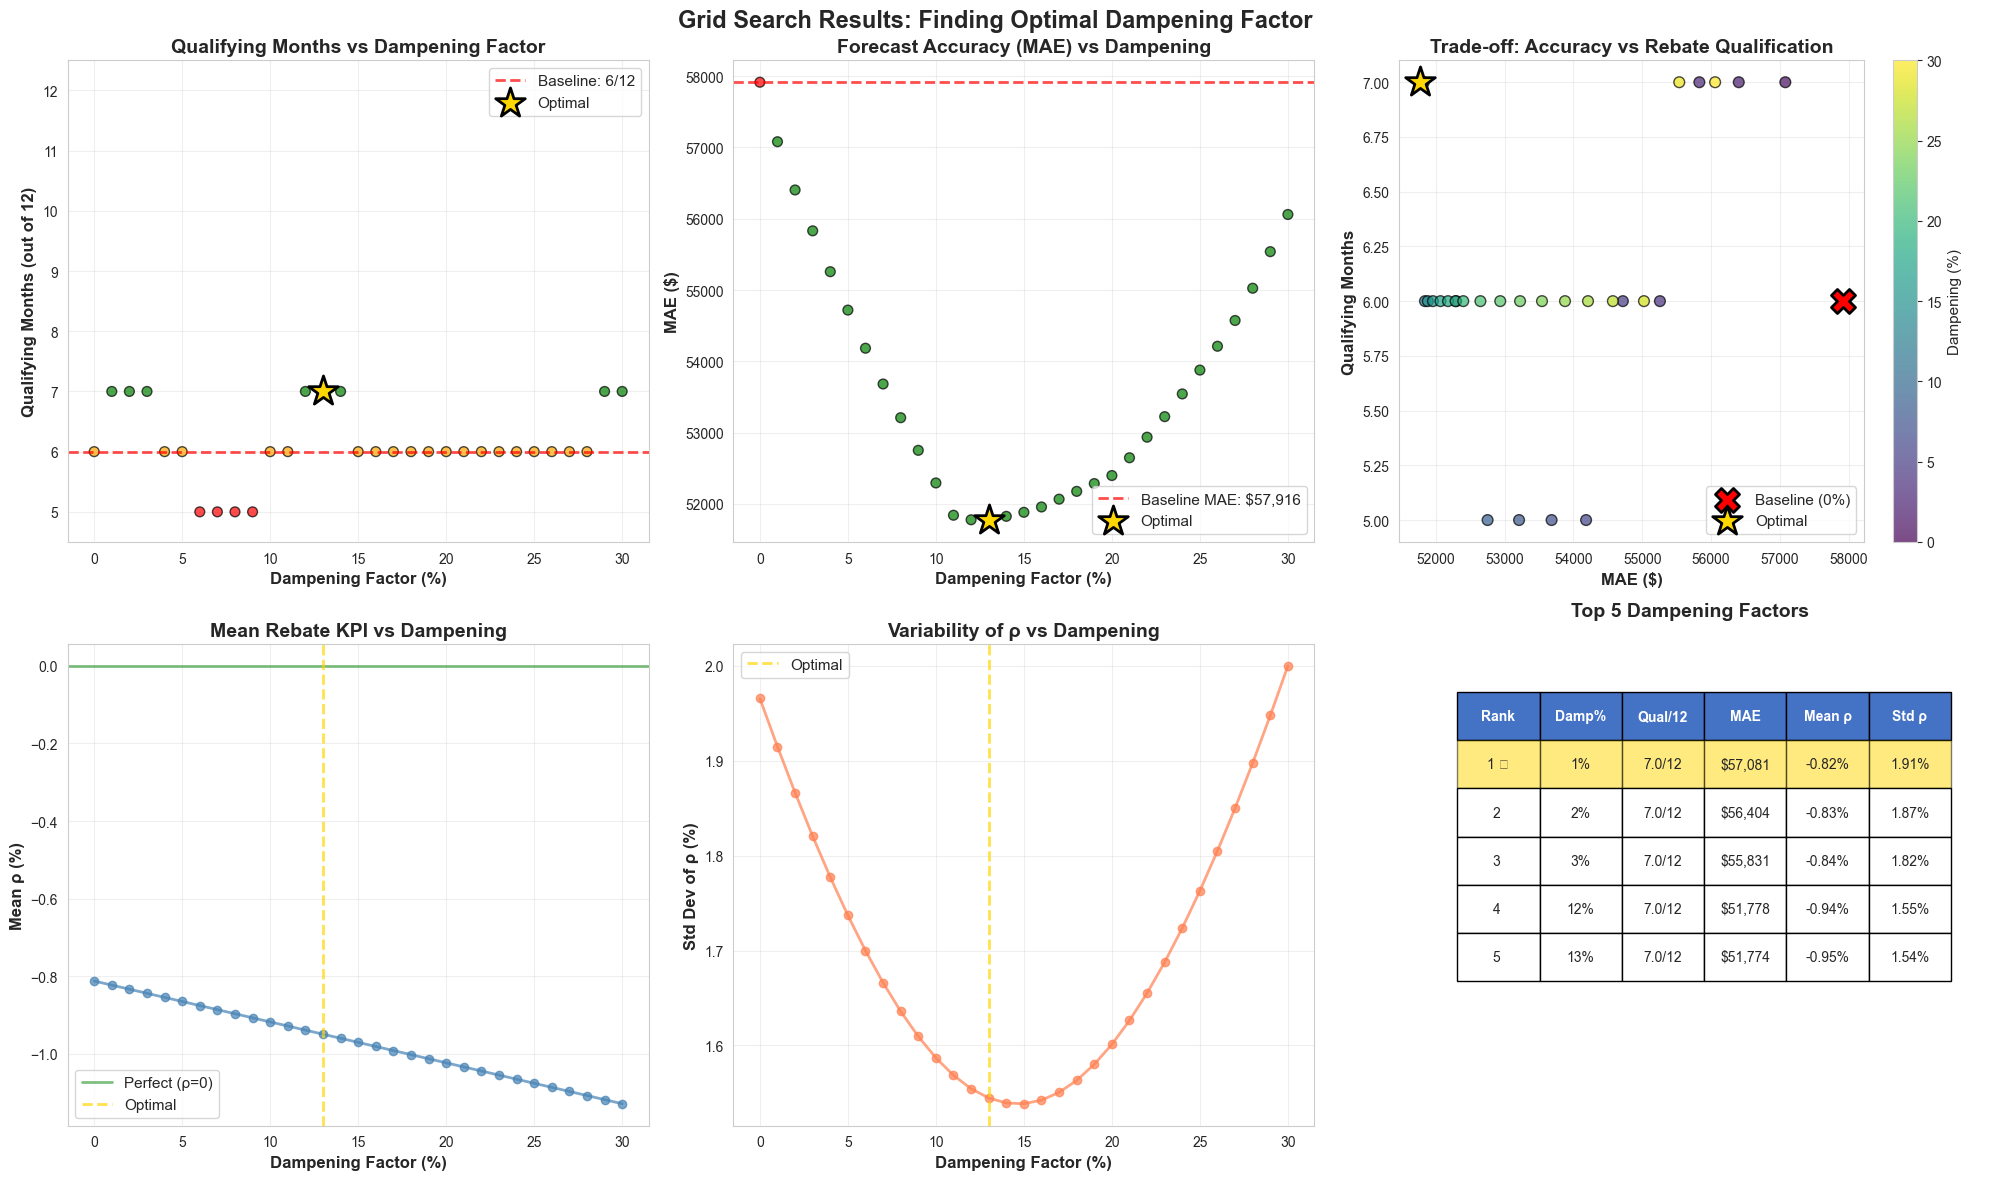


DAMPENING FACTOR COMPARISON

Dampening Qualifying (last 12)     MAE  MAPE Mean ρ Std ρ Max |ρ|
       0%                 6/12 $57,916 3.02% -0.81% 1.97%   4.21%
       5%                 6/12 $54,719 2.87% -0.87% 1.74%   3.93%
      10%                 6/12 $52,294 2.76% -0.92% 1.59%   3.65%
      15%                 6/12 $51,883 2.73% -0.97% 1.54%   3.37%
      20%                 6/12 $52,398 2.73% -1.02% 1.60%   3.08%
      25%                 6/12 $53,878 2.78% -1.08% 1.76%   3.66%

 RECOMMENDED: 15% dampening
   Maximizes qualifying months (6/12)
   While maintaining good accuracy (MAE: $51,883)

APPLYING OPTIMAL DAMPENING FACTOR: 13%

APPLYING CONSERVATIVE FORECASTING STRATEGY

Strategy: Conservative Forecasting
  Method: Dampen forecasts 13% toward historical mean
  Historical mean: $1,902,516.63
  Damping factor: 0.13

 Strategy applied to 90 weekly forecasts

CALCULATING MONTHLY ρ WITH MODIFIED FORECASTS

 Calculated ρ for 21 months with modified forecasts

EVALUATING STRATEG

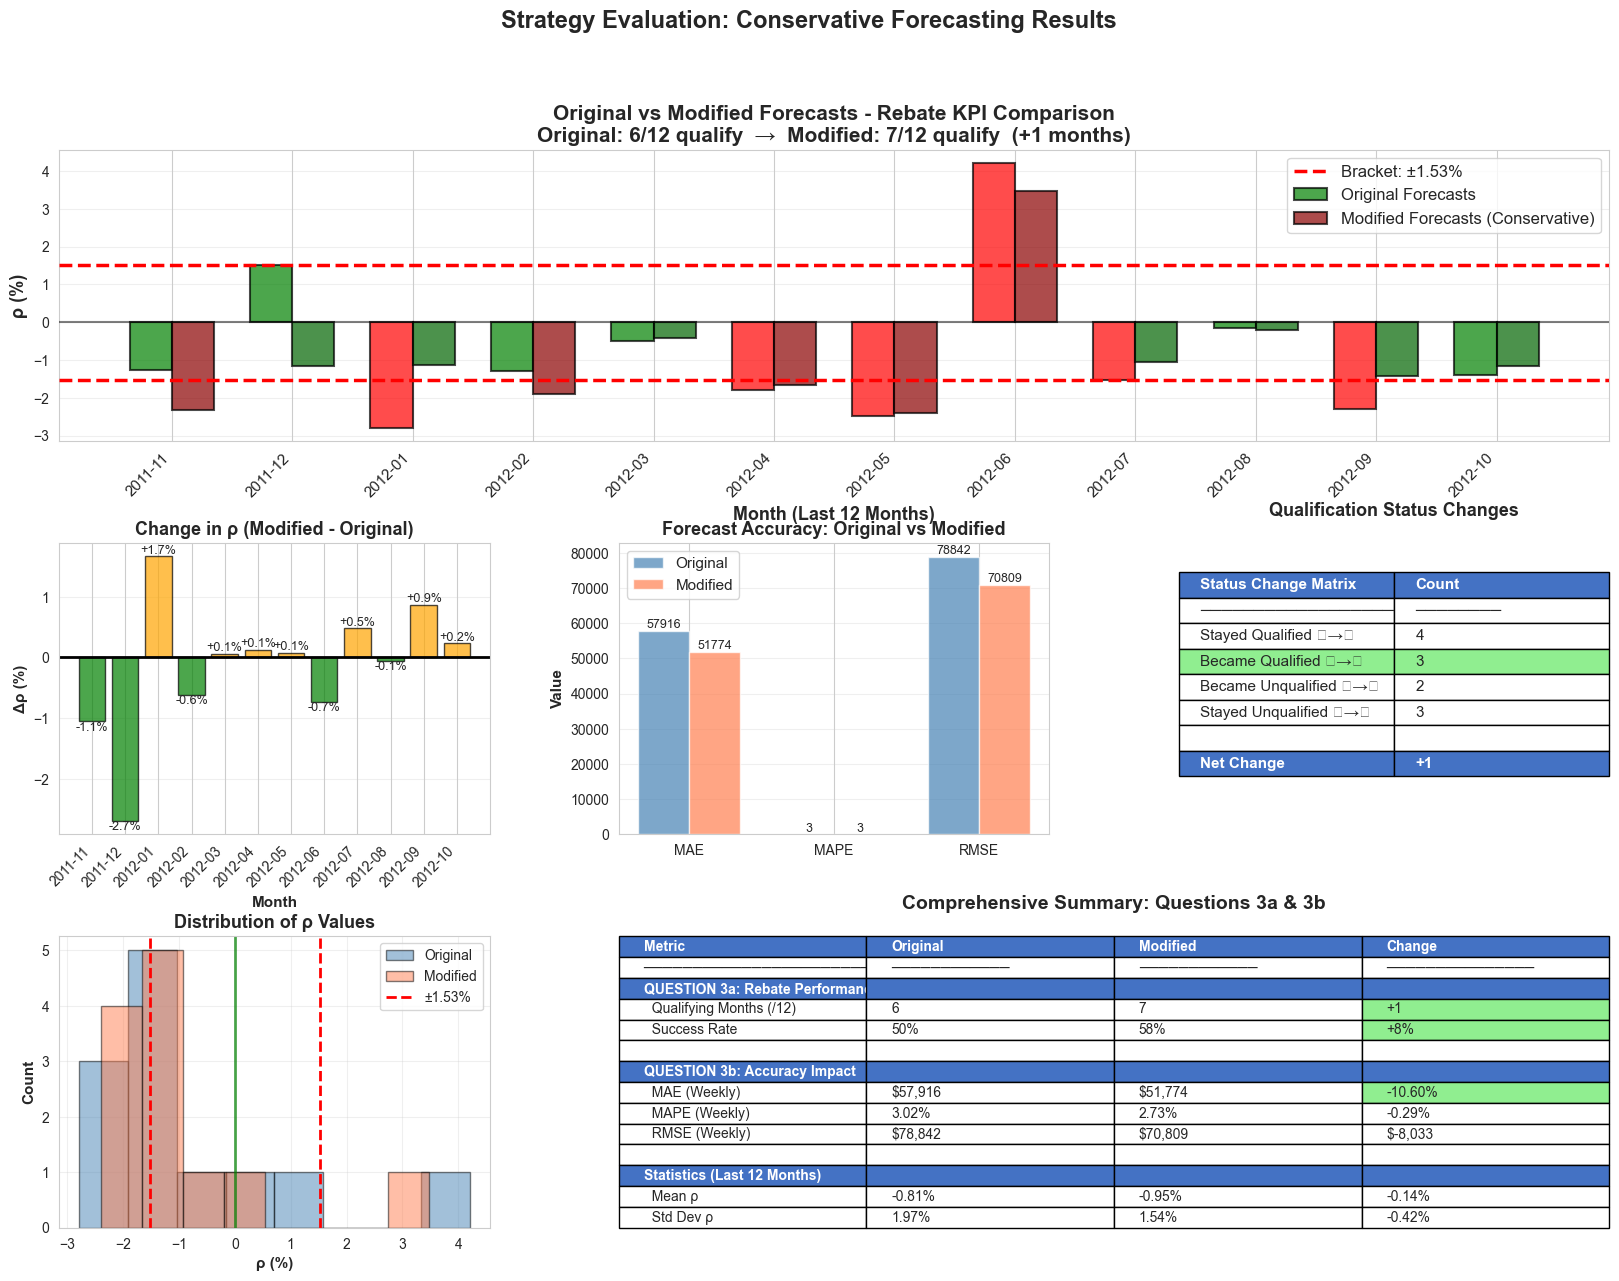


OPTIMAL DAMPENING

Optimal Dampening: 13%

+1 additional months
 MAE changed by -10.60%


In [203]:
# ============================================
# STEP 3.3: GRID SEARCH FOR OPTIMAL DAMPENING
# ============================================

# Run grid search (test dampening from 0% to 30% in 1% increments)
grid_results, optimal_damping = grid_search_dampening_factor(
    forecast_all, 
    monthly_stats_all, 
    X,
    damping_range=np.arange(0.0, 0.31, 0.01)
)

# Visualize grid search results
visualize_grid_search_results(grid_results, X, baseline_qualifying=6)

# Show comparison table
display_dampening_comparison_table(grid_results, key_values=[0.00, 0.05, 0.10, 0.15, 0.20, 0.25])

# Now apply the OPTIMAL dampening factor
print(f"\n{'='*70}")
print(f"APPLYING OPTIMAL DAMPENING FACTOR: {optimal_damping*100:.0f}%")
print(f"{'='*70}")

forecast_modified_optimal, hist_mean = apply_conservative_strategy(
    forecast_all, 
    damping_factor=optimal_damping
)

# Calculate monthly ρ with optimal dampening
monthly_modified_optimal = calculate_monthly_rho_with_strategy(forecast_modified_optimal)

# Evaluate with optimal dampening
evaluation_optimal = evaluate_strategy_performance(
    monthly_modified_optimal, 
    forecast_modified_optimal, 
    X
)

# Visualize final results with optimal dampening
visualize_strategy_results(evaluation_optimal['last_12_stats'], X, evaluation_optimal)

print(f"\n{'='*70}")
print("OPTIMAL DAMPENING")
print(f"{'='*70}")
print(f"\nOptimal Dampening: {optimal_damping*100:.0f}%")
print(f"\n{evaluation_optimal['additional_months']:+d} additional months")
print(f" MAE changed by {evaluation_optimal['mae_change_pct']:+.2f}%")

## Limitations and Considerations

1. **Data Limitations**
   - Only 2.5 years of historical data (143 weeks)
   - Limited to 21 months for horizon-2 analysis (need 52 weeks for initialization)
   - Only analyzing Store 2 - results may not generalize to other stores

2. **Model Assumptions**
   - Assumes future patterns similar to past (stationarity)
   - No incorporation of external factors (promotions, competitors, economy)
   - Fixed seasonal pattern (52-week cycle)

3. **Strategy Limitations**
   - Dampening is a post-hoc adjustment, not part of the model
   - Assumes supplier contract terms remain constant
   - Historical mean may drift over time

4. **Business Context**
   - Rebate contract terms (±X%) determined historically
   - Actual supplier may use different evaluation criteria
   - Does not account for inventory holding costs vs. stockout costs

---